In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from sklearn import metrics
from statsmodels.graphics.api import abline_plot

warnings.filterwarnings("ignore")


def plot_corr(df, method="pearson", negative=False, annotation=True, figsize=(12,8)):
    """
    Plot correlation matrix for df.
    """
    # Factorize
    dtf_corr = df.copy()
    for col in dtf_corr.columns:
        if dtf_corr[col].dtype == "O":
            dtf_corr[col] = dtf_corr[col].factorize(sort=True)[0]
    # Corr matrix
    dtf_corr = dtf_corr.corr(method=method)
    dtf_corr = dtf_corr if negative is True else dtf_corr.abs()
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(dtf_corr, annot=annotation, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
    plt.title(method + " correlation")
    plt.show()


def evaluate_regression_model(y_test, predicted, plt_title=None, figsize=(25, 5)):
    # Evaluation stats
    print("R2 (explained variance):", round(metrics.r2_score(y_test, predicted), 2))
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test - predicted) / predicted)), 2))
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
          "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))

    # Residuals
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(
        residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))

    # Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    ax[0].scatter(predicted, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true - max_error, color='red', linestyle='--', alpha=0.7,
                 label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    # Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()

    # Plot residuals distribution
    sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade": True}, ax=ax[2],
                 label="mean = " + "{:,.0f}".format(np.mean(residuals)))
    ax[2].grid(True)
    ax[2].set(yticks=[], yticklabels=[], title="Residuals distribution")
    if plt_title is None:
        plt.suptitle(f"Regression for {targets[target_idx]}\n\n", fontsize=20)
    else:
        plt.suptitle(plt_title, fontsize=20)
    plt.show()



leaf_clust_df = pd.read_csv("leaf_clust_df.csv")

In [7]:
numerical = [i for i in leaf_clust_df if i.startswith("clr")]  # numerical features
features = numerical + ["Cultivar", "Maturity5"]  # all features

In [8]:
targets = ["RendVendable", "RendPetit", "RendMoy", "RendGros"]  # possible target features

In [9]:
df = leaf_clust_df[features + targets]

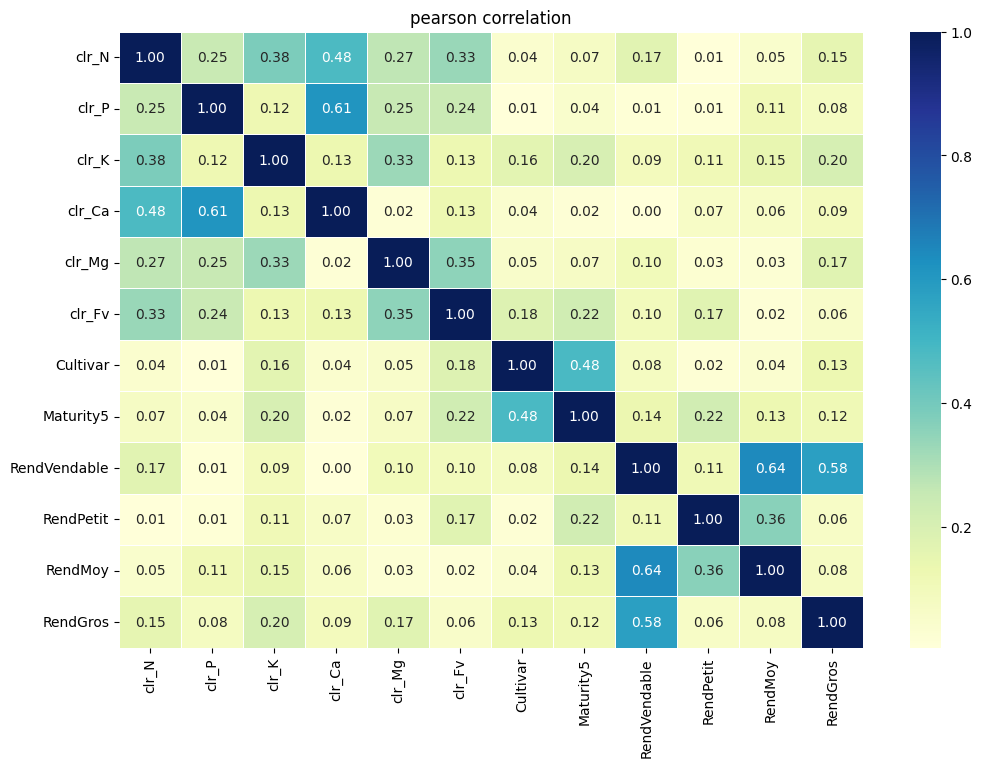

In [10]:
# Correlation heatmap
plot_corr(df)

In [11]:
# Drop rows with Na Values
df.dropna(inplace=True)

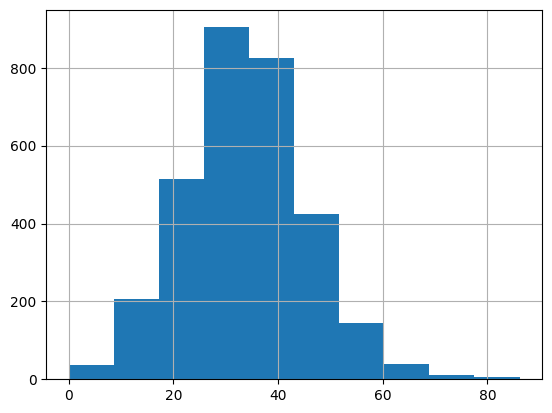

In [12]:
df['RendVendable'].hist();

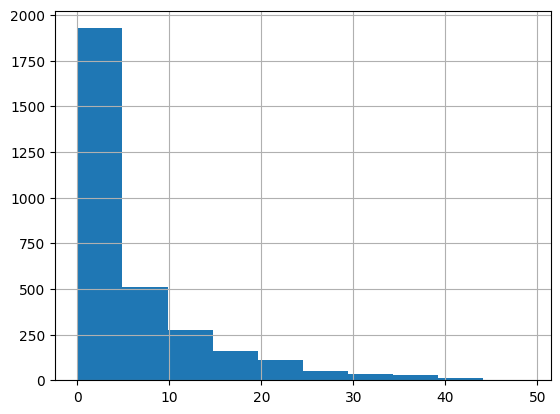

In [13]:
df['RendGros'].hist();


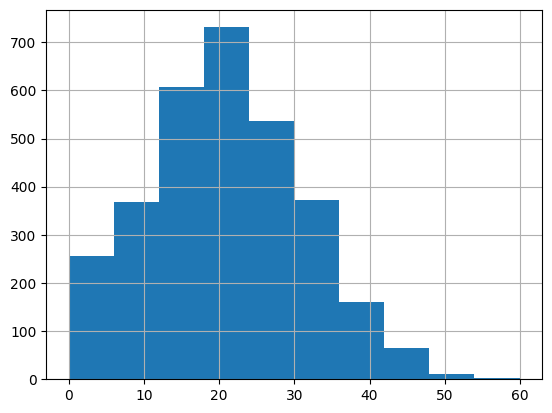

In [14]:
df['RendMoy'].hist();


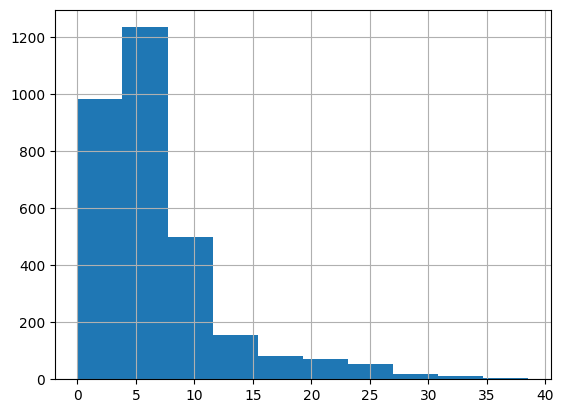

In [15]:
df['RendPetit'].hist();


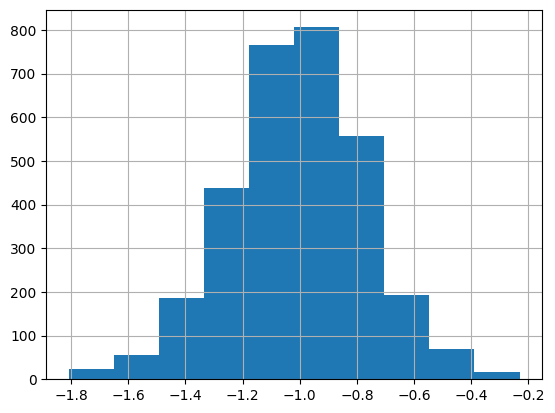

In [16]:
df["clr_Ca"].hist();

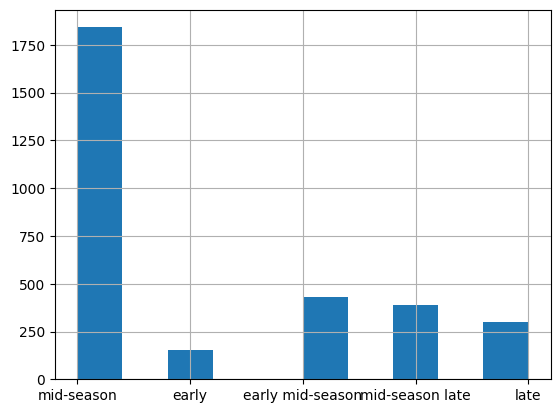

In [17]:
df['Maturity5'].hist();

In [18]:
def add_dummies(df, x, dropx=False):
    """
    Transforms a categorical column into dummy columns
    Args:
        df: dataframe - feature matrix dtf
        x: str - column name
        dropx: logic - whether the x column should be dropped
    Returns:
        df with dummy columns added
    """
    df_dummy = pd.get_dummies(df[x], prefix=x, drop_first=True, dummy_na=False)
    df = pd.concat([df, df_dummy], axis=1)
    if dropx:
        df = df.drop(x, axis=1)
    return df


# Handling categorical features
df = add_dummies(df, x="Maturity5", dropx=True)
df = add_dummies(df, x="Cultivar", dropx=True)

In [19]:
# Define features to predict target from
new_features = list(df.columns)
for x in targets:
    new_features.remove(x)

# Target = RendVendable

### Train / test split

In [20]:
from sklearn.model_selection import train_test_split

# Train/test split

target_idx = 0  # Decide what variable to consider target from list ['RendVendable', 'RendPetit', 'RendMoy', 'RendGros']
X = df[new_features]
y = df[targets[target_idx]]
print(f"Target = {targets[target_idx]}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8539)


Target = RendVendable


### Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

# Scaling
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train[numerical] = X_scaler.fit_transform(X_train[numerical])
X_test[numerical] = X_scaler.transform(X_test[numerical])
y_train = y_scaler.fit_transform(pd.DataFrame(y_train, columns=[targets[target_idx]])).ravel()
y_test = y_scaler.transform(pd.DataFrame(y_test, columns=[targets[target_idx]])).ravel()

In [22]:
import pickle

# Save scalers
with open('models/X_scaler.pickle', 'wb') as output:
    pickle.dump(X_scaler, output)

with open('models/RendVendable_scaler.pickle', 'wb') as output:
    pickle.dump(y_scaler, output)

### Fitting Random Forest, Linear Regression & Multilayer perceptron

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV



rf = RandomForestRegressor(random_state=42)  # Random Forest
lr = LinearRegression()  # Linear Regression
nn = MLPRegressor()  # Multi-layer perceptron


# Define the grid of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lr_params = {
    'fit_intercept': [True, False]
}

nn_params = {
    'hidden_layer_sizes': [(10,), (20,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}


# Create a grid search objects
rf_gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1)
lr_gs = GridSearchCV(estimator=lr, param_grid=lr_params, cv=3, n_jobs=-1)
nn_gs = GridSearchCV(estimator=nn, param_grid=nn_params, cv=3, n_jobs=-1)


# Fit the grid search objects to the data
rf_gs.fit(X_train, y_train)
lr_gs.fit(X_train, y_train)
nn_gs.fit(X_train, y_train)


# Print the best hyperparameters and best score
print("Random Forest - Best Hyperparameters:", rf_gs.best_params_)
print("Random Forest - Best Score:", rf_gs.best_score_)
print()
print("Linear Regression - Best Hyperparameters:", lr_gs.best_params_)
print("Linear Regression - Best Score:", lr_gs.best_score_)
print()
print("Multi-layer perceptron - Best Hyperparameters:", nn_gs.best_params_)
print("Multi-layer perceptron - Best Score:", nn_gs.best_score_)
print("---------------")

# Evaluate the best model on the test data
rf_best = rf_gs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE on test data:", mse)

lr_best = lr_gs.best_estimator_
y_pred_lr = lr_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE on test data:", mse)

nn_best = nn_gs.best_estimator_
y_pred_nn = nn_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nn)
print("Multi-layer perceptron MSE on test data:", mse)

Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Best Score: 0.5355192283855147

Linear Regression - Best Hyperparameters: {'fit_intercept': False}
Linear Regression - Best Score: -2.4748780959535376e+20

Multi-layer perceptron - Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Multi-layer perceptron - Best Score: 0.531268096750773
---------------
Random Forest MSE on test data: 0.4053830053609205
Linear Regression MSE on test data: 0.789289976071183
Multi-layer perceptron MSE on test data: 0.5521637057192511


### Plot feature importances


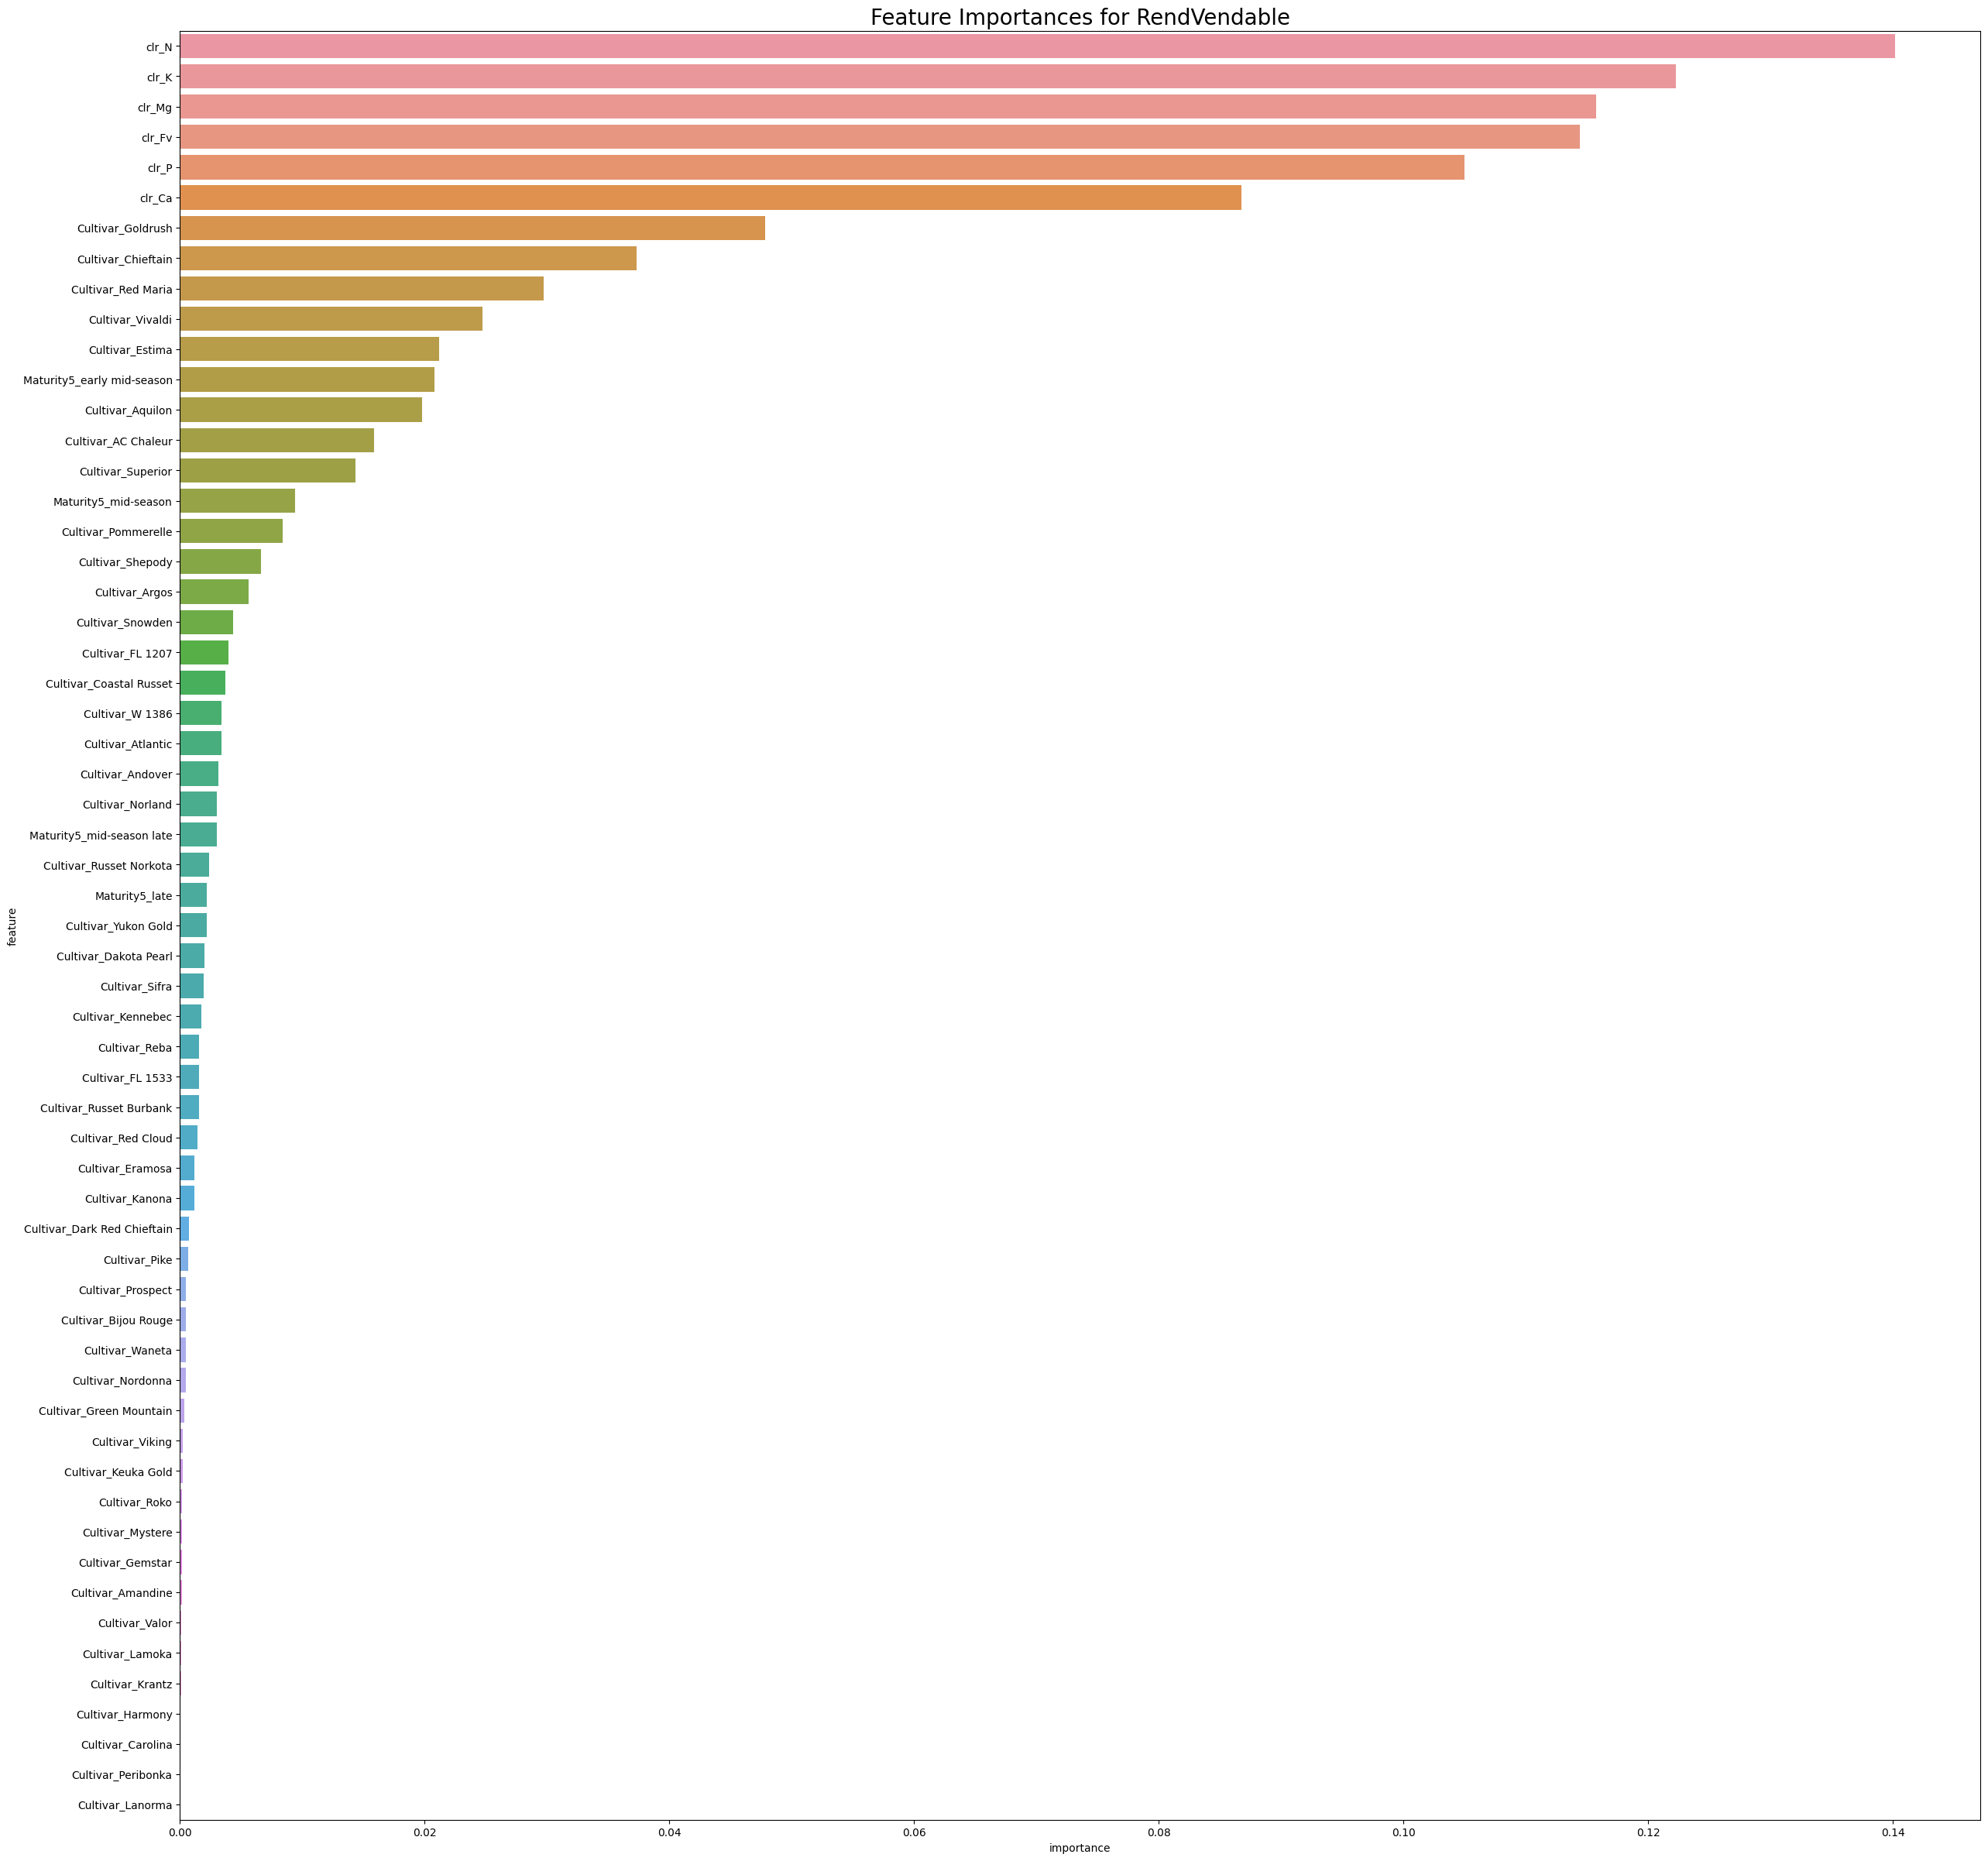

In [24]:
feature_importances = pd.DataFrame({'feature': new_features,
                                    'importance': rf_best.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(30, 30))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title(f'Feature Importances for {targets[target_idx]}', fontsize=20)
plt.show()


### Evaluation on test data

Random forest regressor evaluation
R2 (explained variance): 0.6
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.18
Mean Absolute Error (Σ|y-pred|/n): 6
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 8
Max Error: 36


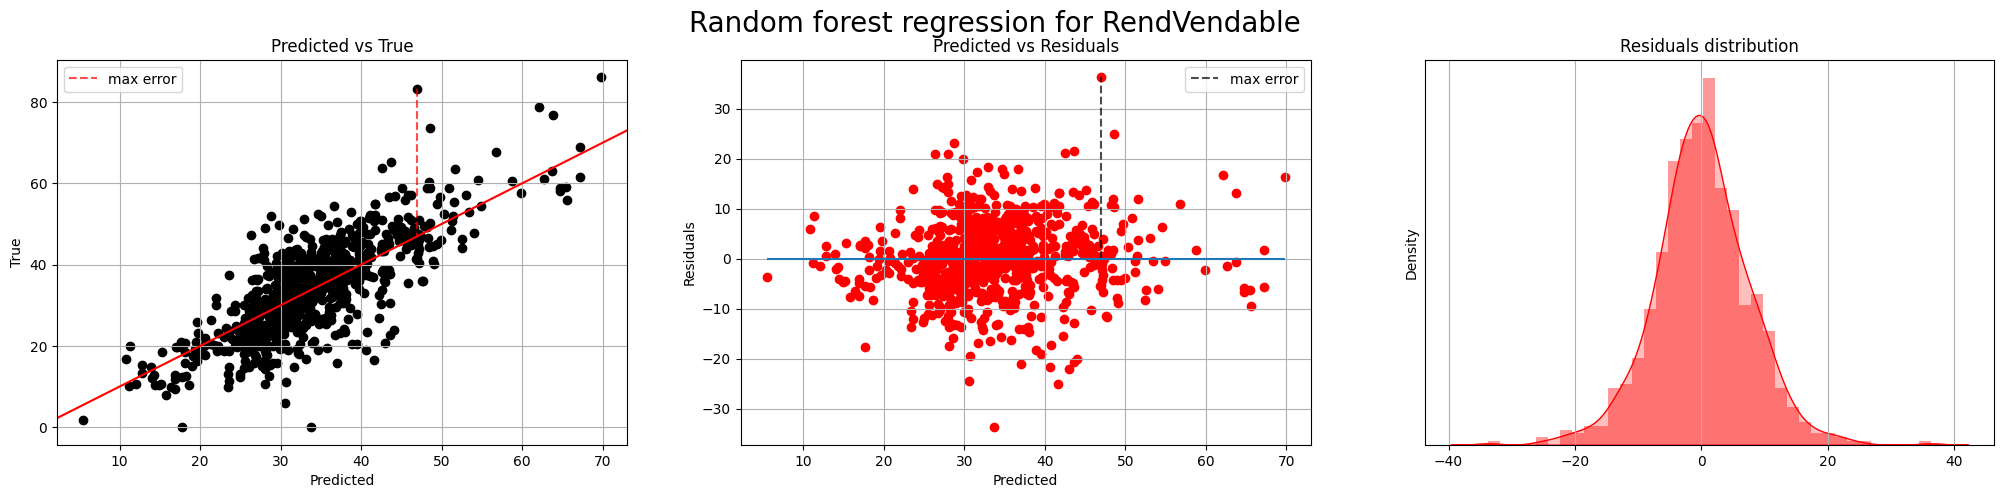


Linear Regression evaluation
R2 (explained variance): 0.23
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.24
Mean Absolute Error (Σ|y-pred|/n): 8
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 11
Max Error: 50


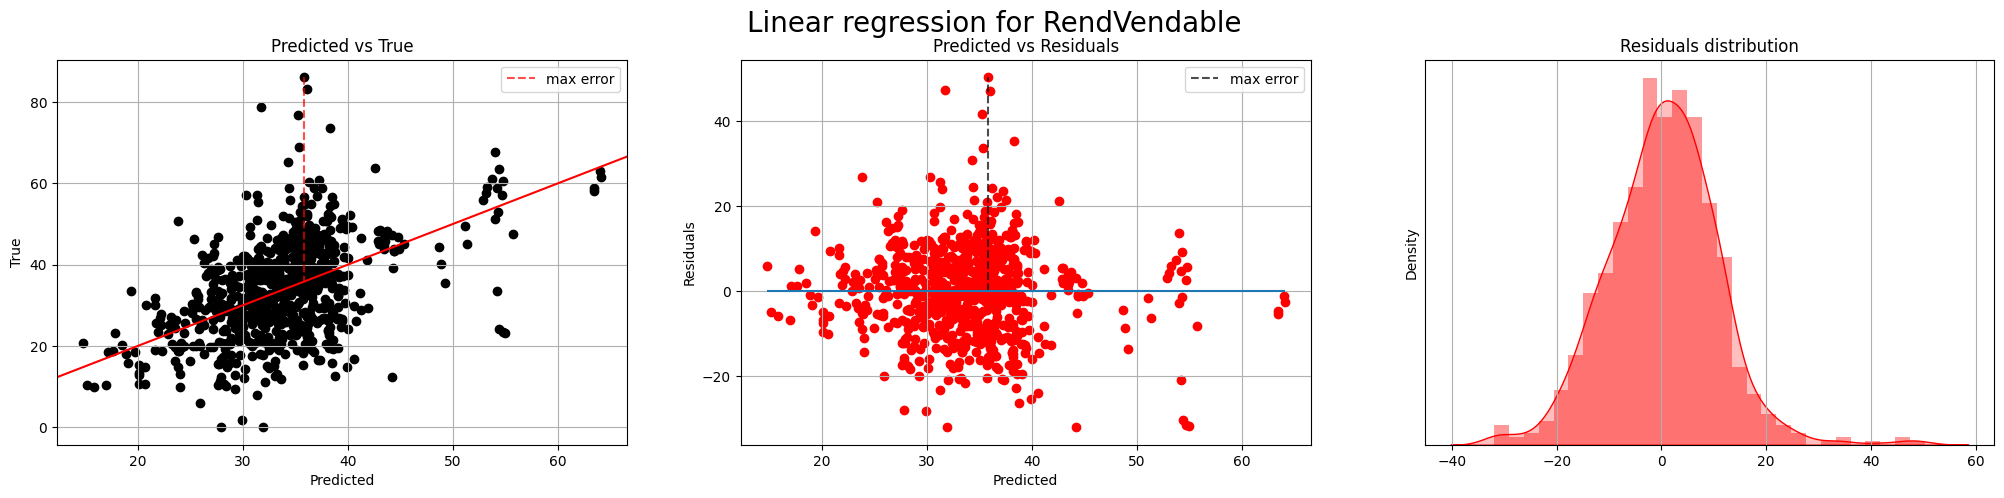


Multi-layer perceptron evaluation
R2 (explained variance): 0.46
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.22
Mean Absolute Error (Σ|y-pred|/n): 6
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 9
Max Error: 49


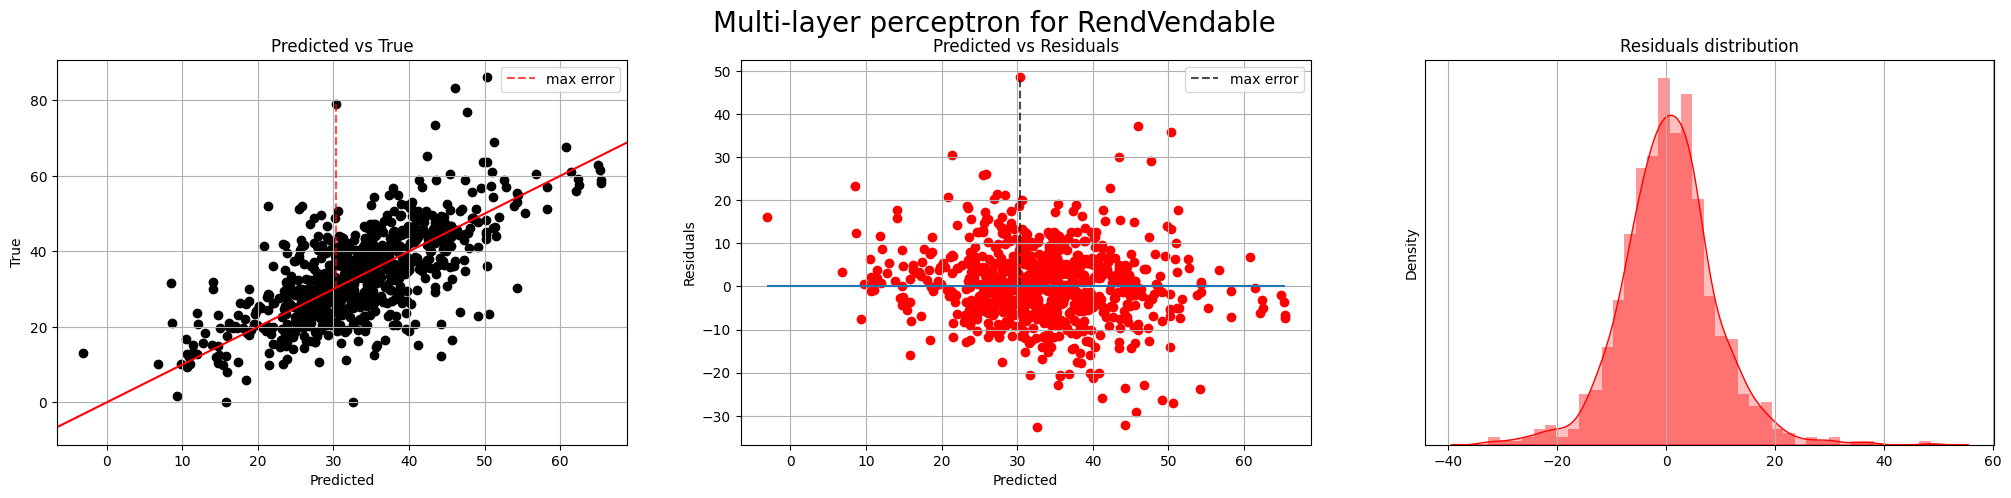

In [25]:
# Evaluate on test data
real_y_test = y_scaler.inverse_transform([y_test])  # Inverse transform to get back to real distribution
real_y_pred_rf = y_scaler.inverse_transform([y_pred_rf])
real_y_pred_lr = y_scaler.inverse_transform([y_pred_lr])
real_y_pred_nn = y_scaler.inverse_transform([y_pred_nn])

print("Random forest regressor evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_rf[0], plt_title=f"Random forest regression for {targets[target_idx]}")
print()

print("Linear Regression evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_lr[0], plt_title=f"Linear regression for {targets[target_idx]}")
print()

print("Multi-layer perceptron evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_nn[0], plt_title=f"Multi-layer perceptron for {targets[target_idx]}")
print()

In [26]:
import joblib

joblib.dump(rf_best, 'models/randomForest_RendVendable.pkl')
joblib.dump(lr_best, 'models/linearRegression_RendVendable.pkl')
joblib.dump(nn_best, 'models/multilayerPerceptron_RendVendable.pkl')


['models/multilayerPerceptron_RendVendable.pkl']

# Target = RendPetit

### Train / test split

In [27]:
from sklearn.model_selection import train_test_split

# Train/test split

target_idx = 1  # Decide what variable to consider target from list ['RendVendable', 'RendPetit', 'RendMoy', 'RendGros']
X = df[new_features]
y = df[targets[target_idx]]
print(f"Target = {targets[target_idx]}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8539)


Target = RendPetit


### Scaling

In [28]:
from sklearn.preprocessing import StandardScaler

# Scaling
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train[numerical] = X_scaler.fit_transform(X_train[numerical])
X_test[numerical] = X_scaler.transform(X_test[numerical])
y_train = y_scaler.fit_transform(pd.DataFrame(y_train, columns=[targets[target_idx]])).ravel()
y_test = y_scaler.transform(pd.DataFrame(y_test, columns=[targets[target_idx]])).ravel()

In [29]:
with open('models/RendPetit_scaler.pickle', 'wb') as output:
    pickle.dump(y_scaler, output)

### Fitting Random Forest, Linear Regression & Multilayer perceptron

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV



rf = RandomForestRegressor(random_state=42)  # Random Forest
lr = LinearRegression()  # Linear Regression
nn = MLPRegressor()  # Multi-layer perceptron


# Define the grid of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lr_params = {
    'fit_intercept': [True, False]
}

nn_params = {
    'hidden_layer_sizes': [(10,), (20,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}


# Create a grid search objects
rf_gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1)
lr_gs = GridSearchCV(estimator=lr, param_grid=lr_params, cv=3, n_jobs=-1)
nn_gs = GridSearchCV(estimator=nn, param_grid=nn_params, cv=3, n_jobs=-1)


# Fit the grid search objects to the data
rf_gs.fit(X_train, y_train)
lr_gs.fit(X_train, y_train)
nn_gs.fit(X_train, y_train)


# Print the best hyperparameters and best score
print("Random Forest - Best Hyperparameters:", rf_gs.best_params_)
print("Random Forest - Best Score:", rf_gs.best_score_)
print()
print("Linear Regression - Best Hyperparameters:", lr_gs.best_params_)
print("Linear Regression - Best Score:", lr_gs.best_score_)
print()
print("Multi-layer perceptron - Best Hyperparameters:", nn_gs.best_params_)
print("Multi-layer perceptron - Best Score:", nn_gs.best_score_)
print("---------------")

# Evaluate the best model on the test data
rf_best = rf_gs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE on test data:", mse)

lr_best = lr_gs.best_estimator_
y_pred_lr = lr_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE on test data:", mse)

nn_best = nn_gs.best_estimator_
y_pred_nn = nn_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nn)
print("Multi-layer perceptron MSE on test data:", mse)

Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Best Score: 0.6673849228474765

Linear Regression - Best Hyperparameters: {'fit_intercept': True}
Linear Regression - Best Score: -3.5398894044489477e+18

Multi-layer perceptron - Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Multi-layer perceptron - Best Score: 0.7134736411402661
---------------
Random Forest MSE on test data: 0.2968901314721194
Linear Regression MSE on test data: 0.6252965372216858
Multi-layer perceptron MSE on test data: 0.2562056024234925


### Plot feature importances


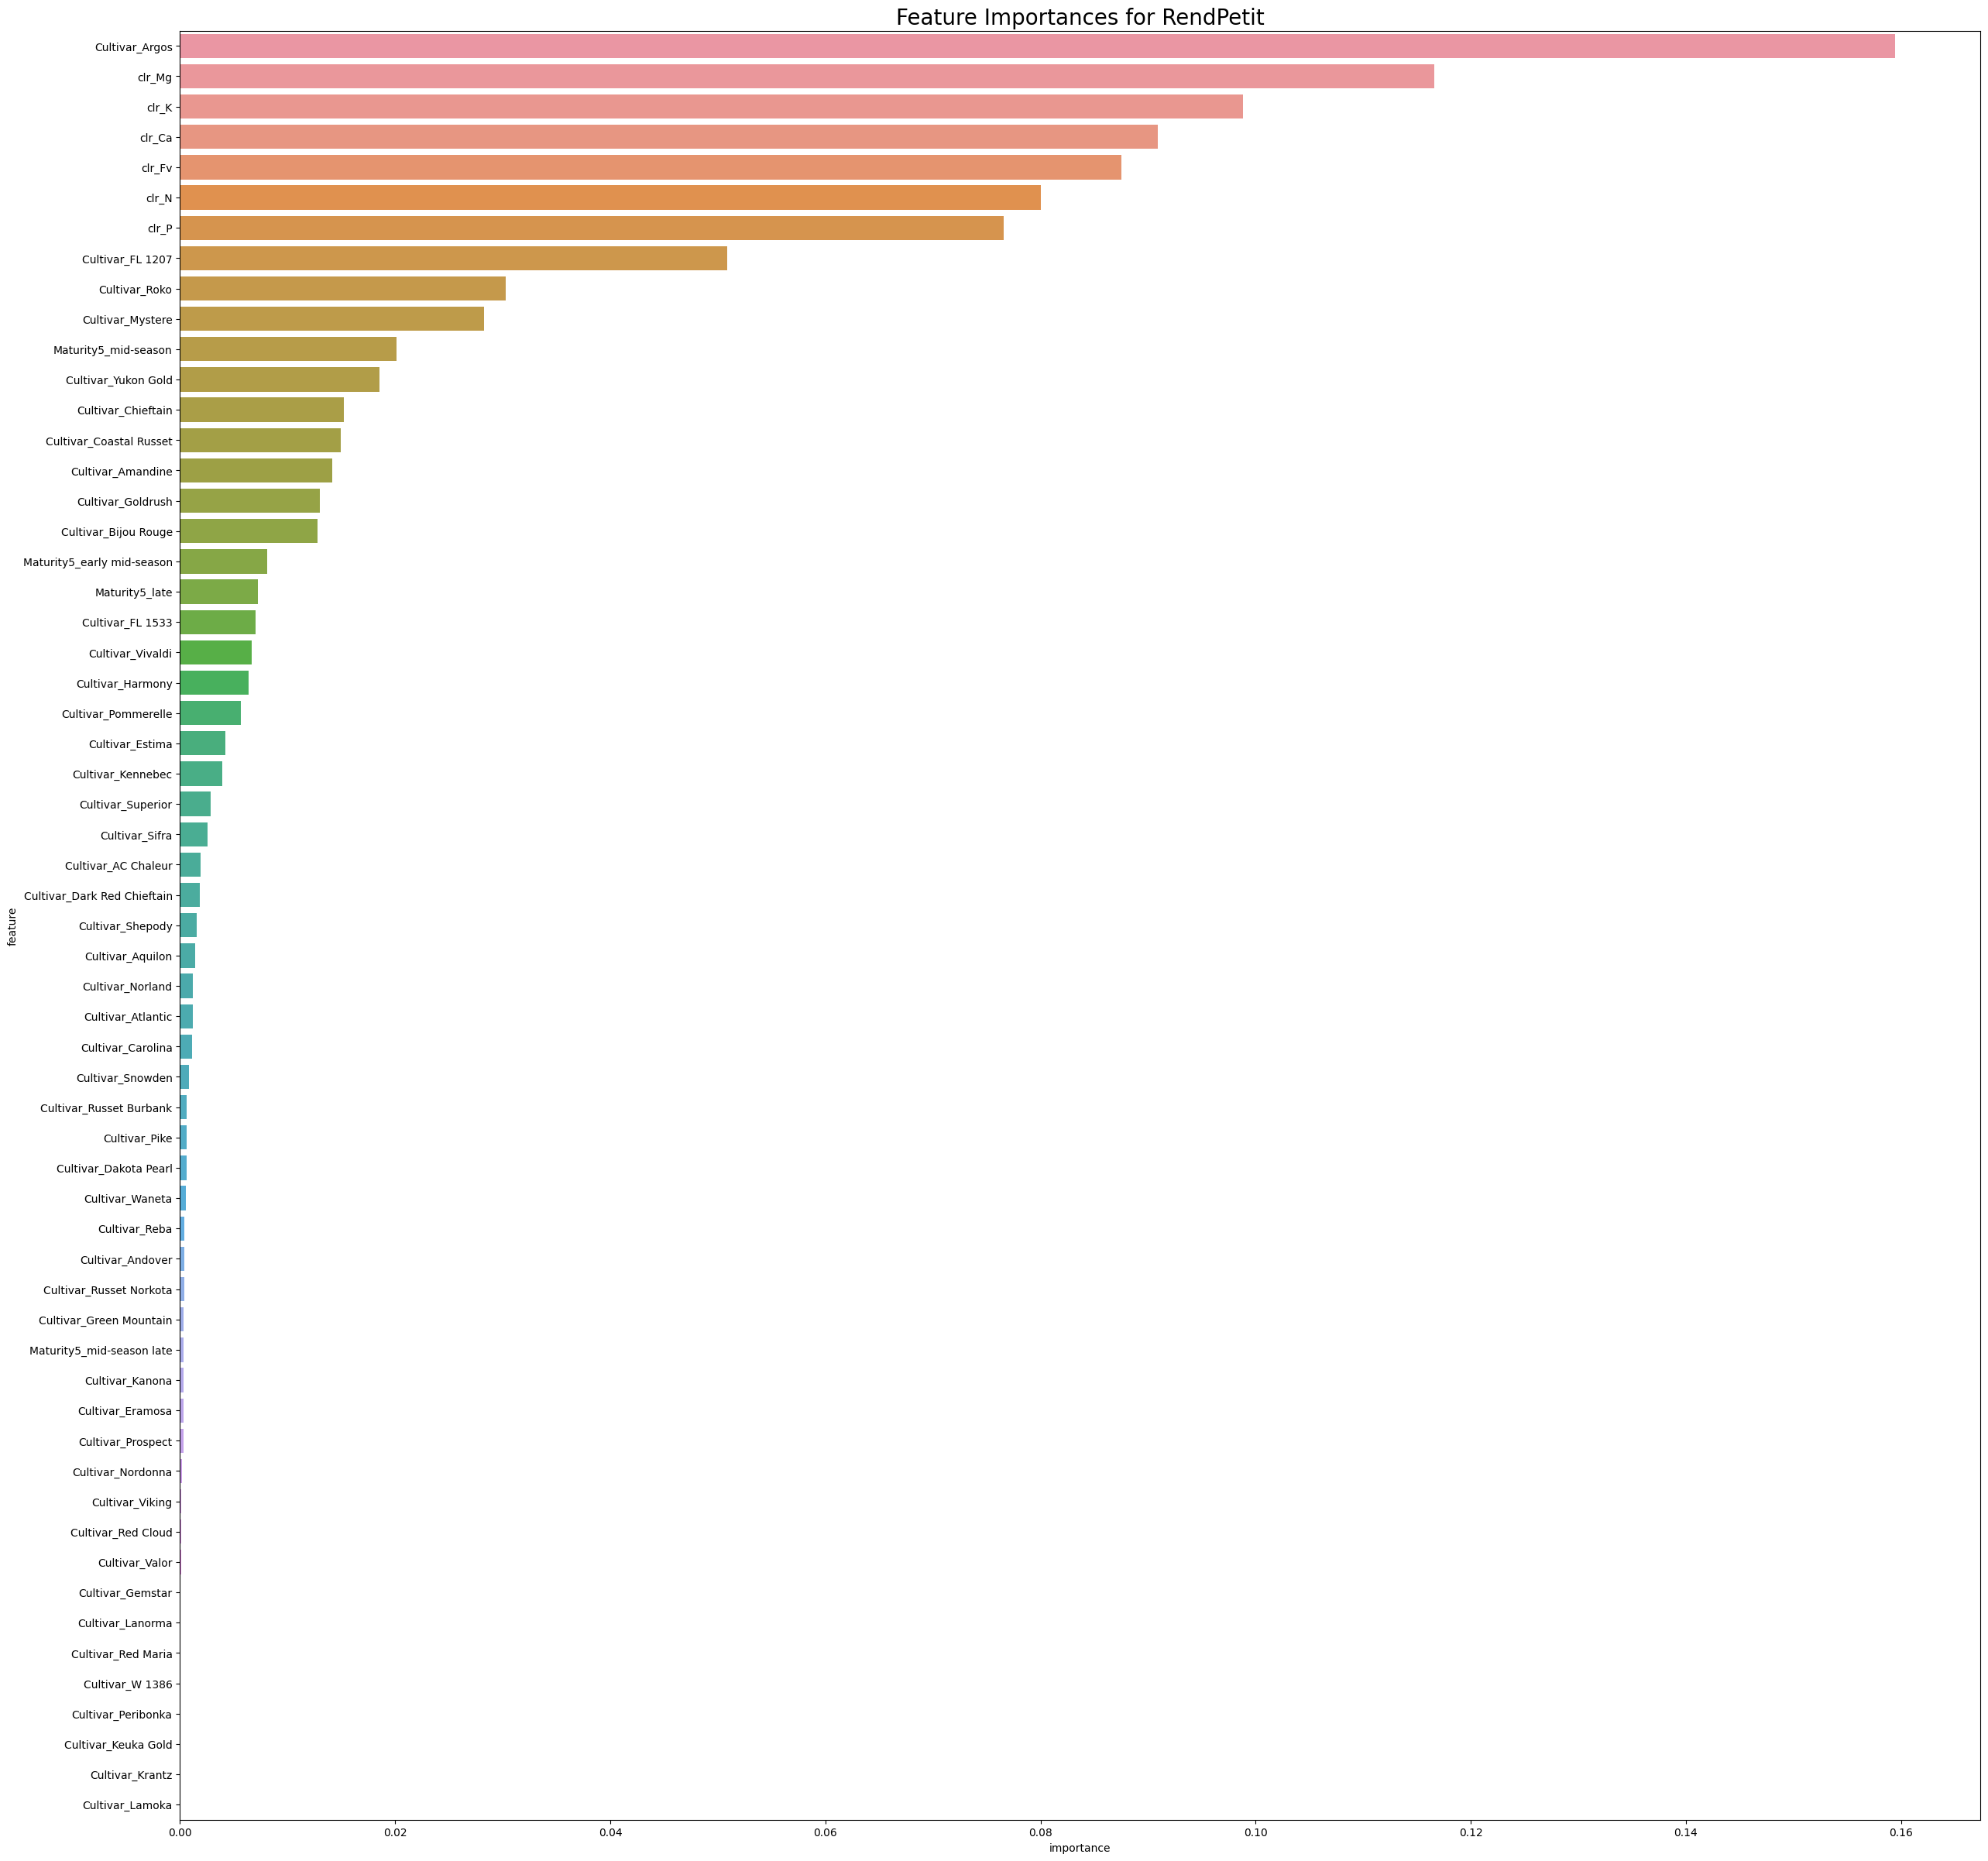

In [31]:
feature_importances = pd.DataFrame({'feature': new_features,
                                    'importance': rf_best.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(30, 30))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title(f'Feature Importances for {targets[target_idx]}', fontsize=20)
plt.show()


### Evaluation on test data

Random forest regressor evaluation
R2 (explained variance): 0.74
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.3
Mean Absolute Error (Σ|y-pred|/n): 2
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 3
Max Error: 21


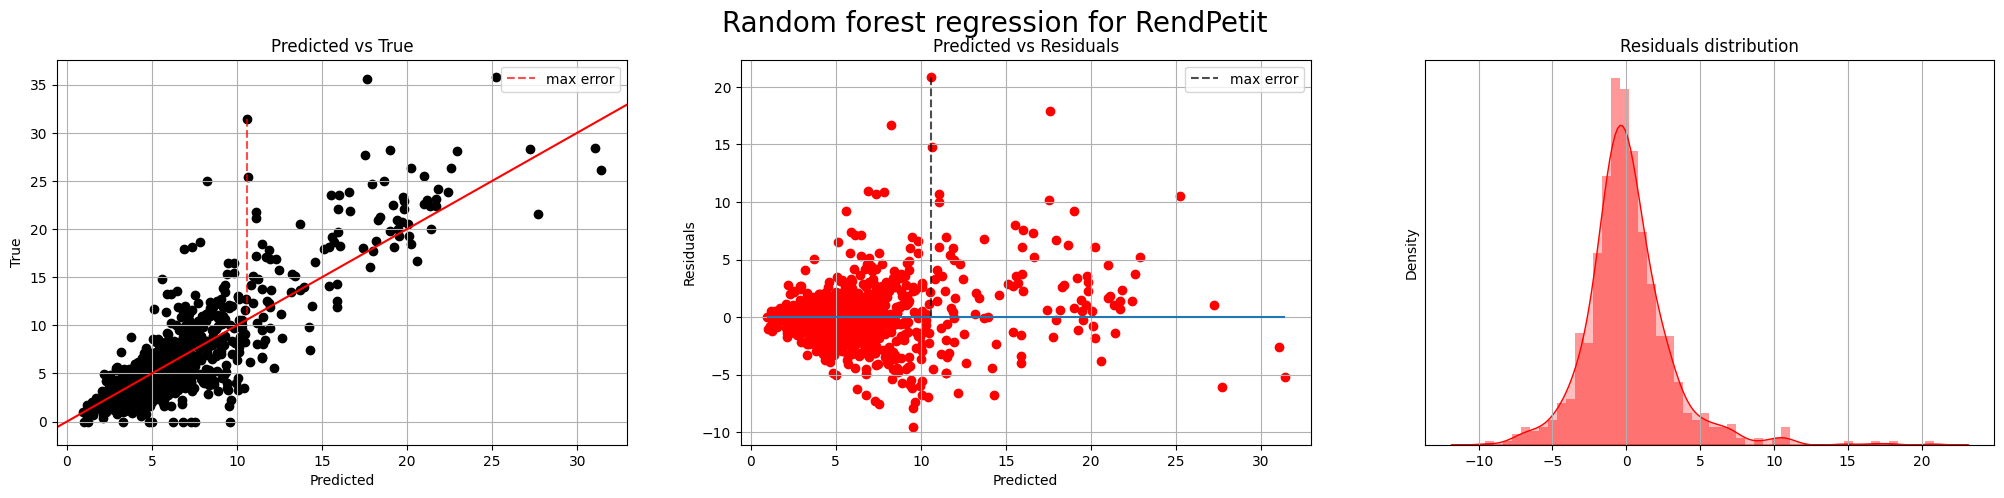


Linear Regression evaluation
R2 (explained variance): 0.45
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.54
Mean Absolute Error (Σ|y-pred|/n): 3
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 4
Max Error: 28


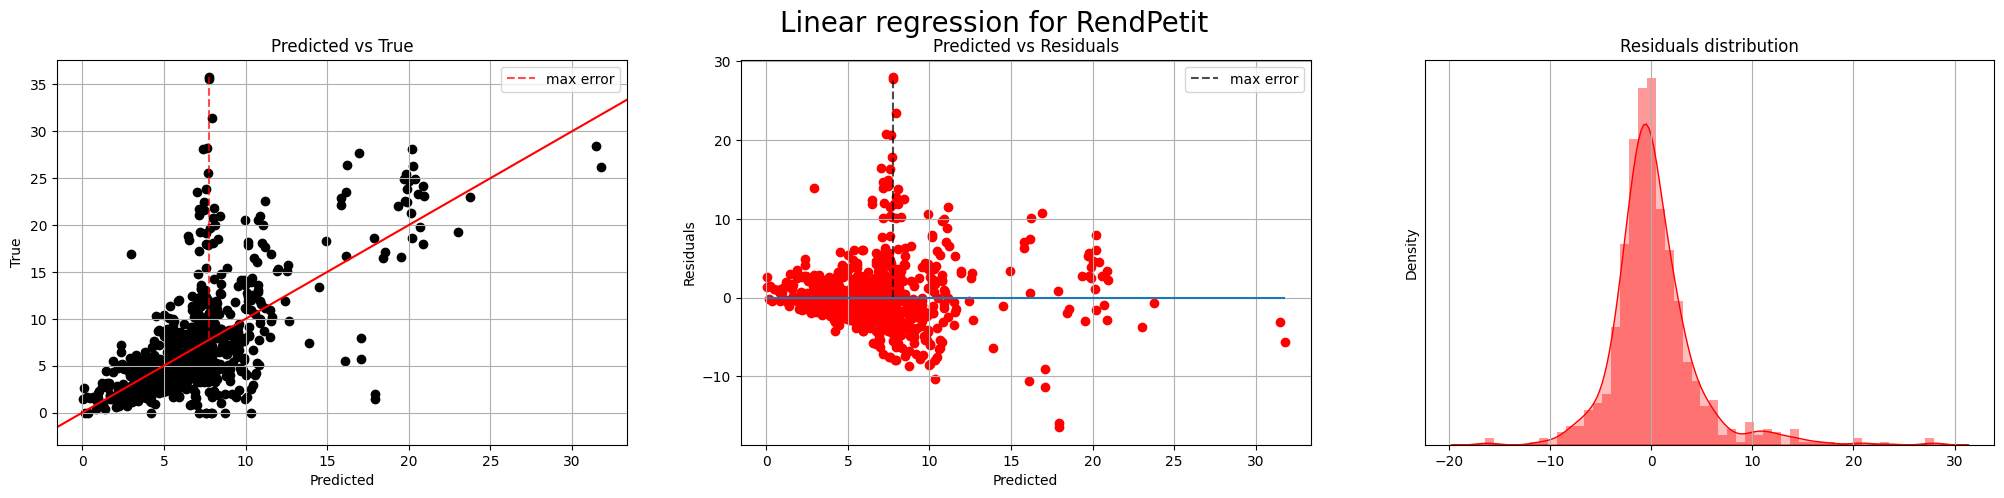


Multi-layer perceptron evaluation
R2 (explained variance): 0.77
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.39
Mean Absolute Error (Σ|y-pred|/n): 2
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 3
Max Error: 16


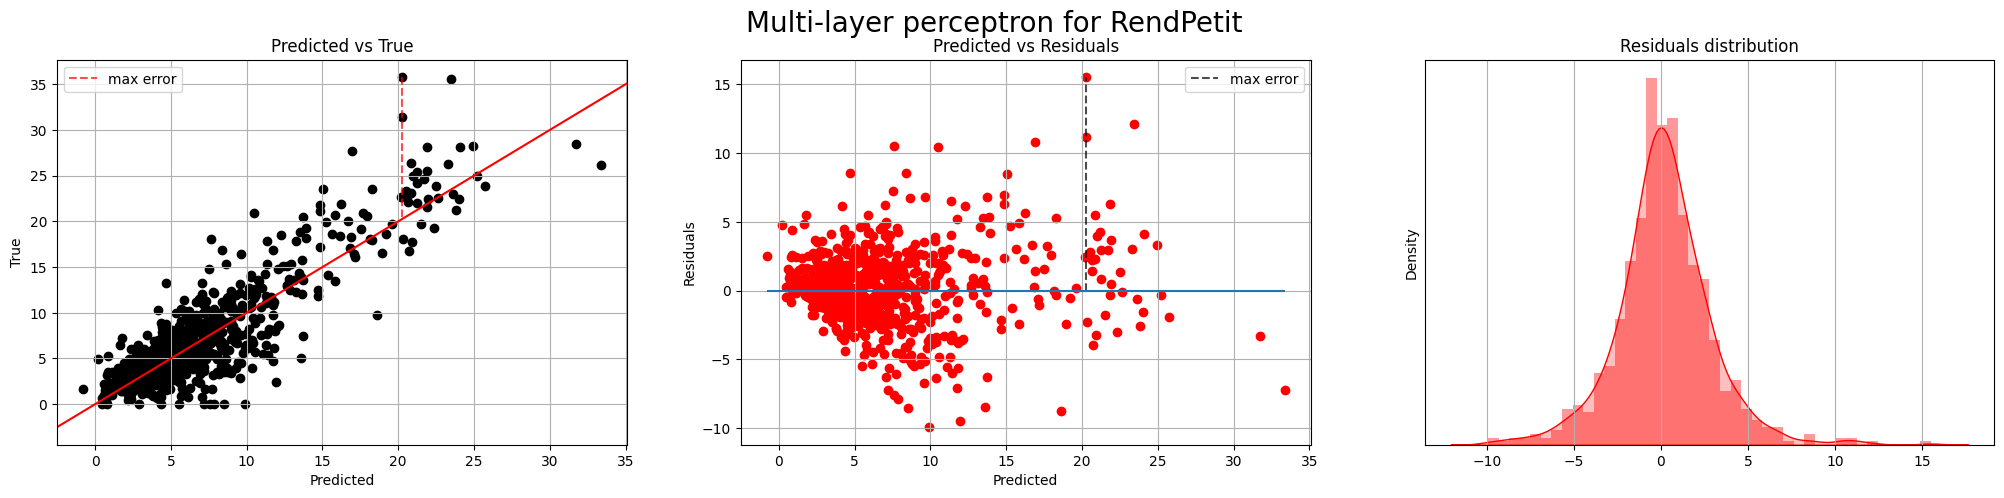

In [32]:
# Evaluate on test data
real_y_test = y_scaler.inverse_transform([y_test])  # Inverse transform to get back to real distribution
real_y_pred_rf = y_scaler.inverse_transform([y_pred_rf])
real_y_pred_lr = y_scaler.inverse_transform([y_pred_lr])
real_y_pred_nn = y_scaler.inverse_transform([y_pred_nn])

print("Random forest regressor evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_rf[0], plt_title=f"Random forest regression for {targets[target_idx]}")
print()

print("Linear Regression evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_lr[0], plt_title=f"Linear regression for {targets[target_idx]}")
print()

print("Multi-layer perceptron evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_nn[0], plt_title=f"Multi-layer perceptron for {targets[target_idx]}")
print()

In [33]:
joblib.dump(rf_best, 'models/randomForest_RendPetit.pkl')
joblib.dump(lr_best, 'models/linearRegression_RendPetit.pkl')
joblib.dump(nn_best, 'models/multilayerPerceptron_RendPetit.pkl')


['models/multilayerPerceptron_RendPetit.pkl']

# Target = RendMoy

### Train / test split

In [34]:
from sklearn.model_selection import train_test_split

# Train/test split

target_idx = 2  # Decide what variable to consider target from list ['RendVendable', 'RendPetit', 'RendMoy', 'RendGros']
X = df[new_features]
y = df[targets[target_idx]]
print(f"Target = {targets[target_idx]}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8539)


Target = RendMoy


### Scaling

In [35]:
from sklearn.preprocessing import StandardScaler

# Scaling
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train[numerical] = X_scaler.fit_transform(X_train[numerical])
X_test[numerical] = X_scaler.transform(X_test[numerical])
y_train = y_scaler.fit_transform(pd.DataFrame(y_train, columns=[targets[target_idx]])).ravel()
y_test = y_scaler.transform(pd.DataFrame(y_test, columns=[targets[target_idx]])).ravel()

In [36]:
with open('models/RendMoy_scaler.pickle', 'wb') as output:
    pickle.dump(y_scaler, output)

### Fitting Random Forest, Linear Regression & Multilayer perceptron

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV



rf = RandomForestRegressor(random_state=42)  # Random Forest
lr = LinearRegression()  # Linear Regression
nn = MLPRegressor()  # Multi-layer perceptron


# Define the grid of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lr_params = {
    'fit_intercept': [True, False]
}

nn_params = {
    'hidden_layer_sizes': [(10,), (20,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}


# Create a grid search objects
rf_gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1)
lr_gs = GridSearchCV(estimator=lr, param_grid=lr_params, cv=3, n_jobs=-1)
nn_gs = GridSearchCV(estimator=nn, param_grid=nn_params, cv=3, n_jobs=-1)


# Fit the grid search objects to the data
rf_gs.fit(X_train, y_train)
lr_gs.fit(X_train, y_train)
nn_gs.fit(X_train, y_train)


# Print the best hyperparameters and best score
print("Random Forest - Best Hyperparameters:", rf_gs.best_params_)
print("Random Forest - Best Score:", rf_gs.best_score_)
print()
print("Linear Regression - Best Hyperparameters:", lr_gs.best_params_)
print("Linear Regression - Best Score:", lr_gs.best_score_)
print()
print("Multi-layer perceptron - Best Hyperparameters:", nn_gs.best_params_)
print("Multi-layer perceptron - Best Score:", nn_gs.best_score_)
print("---------------")

# Evaluate the best model on the test data
rf_best = rf_gs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE on test data:", mse)

lr_best = lr_gs.best_estimator_
y_pred_lr = lr_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE on test data:", mse)

nn_best = nn_gs.best_estimator_
y_pred_nn = nn_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nn)
print("Multi-layer perceptron MSE on test data:", mse)

Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Best Score: 0.608946528921739

Linear Regression - Best Hyperparameters: {'fit_intercept': True}
Linear Regression - Best Score: -4.131567900970251e+20

Multi-layer perceptron - Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Multi-layer perceptron - Best Score: 0.6079723077314068
---------------
Random Forest MSE on test data: 0.34920339700816233
Linear Regression MSE on test data: 0.5692611452391972
Multi-layer perceptron MSE on test data: 0.3603307550248659


### Plot feature importances


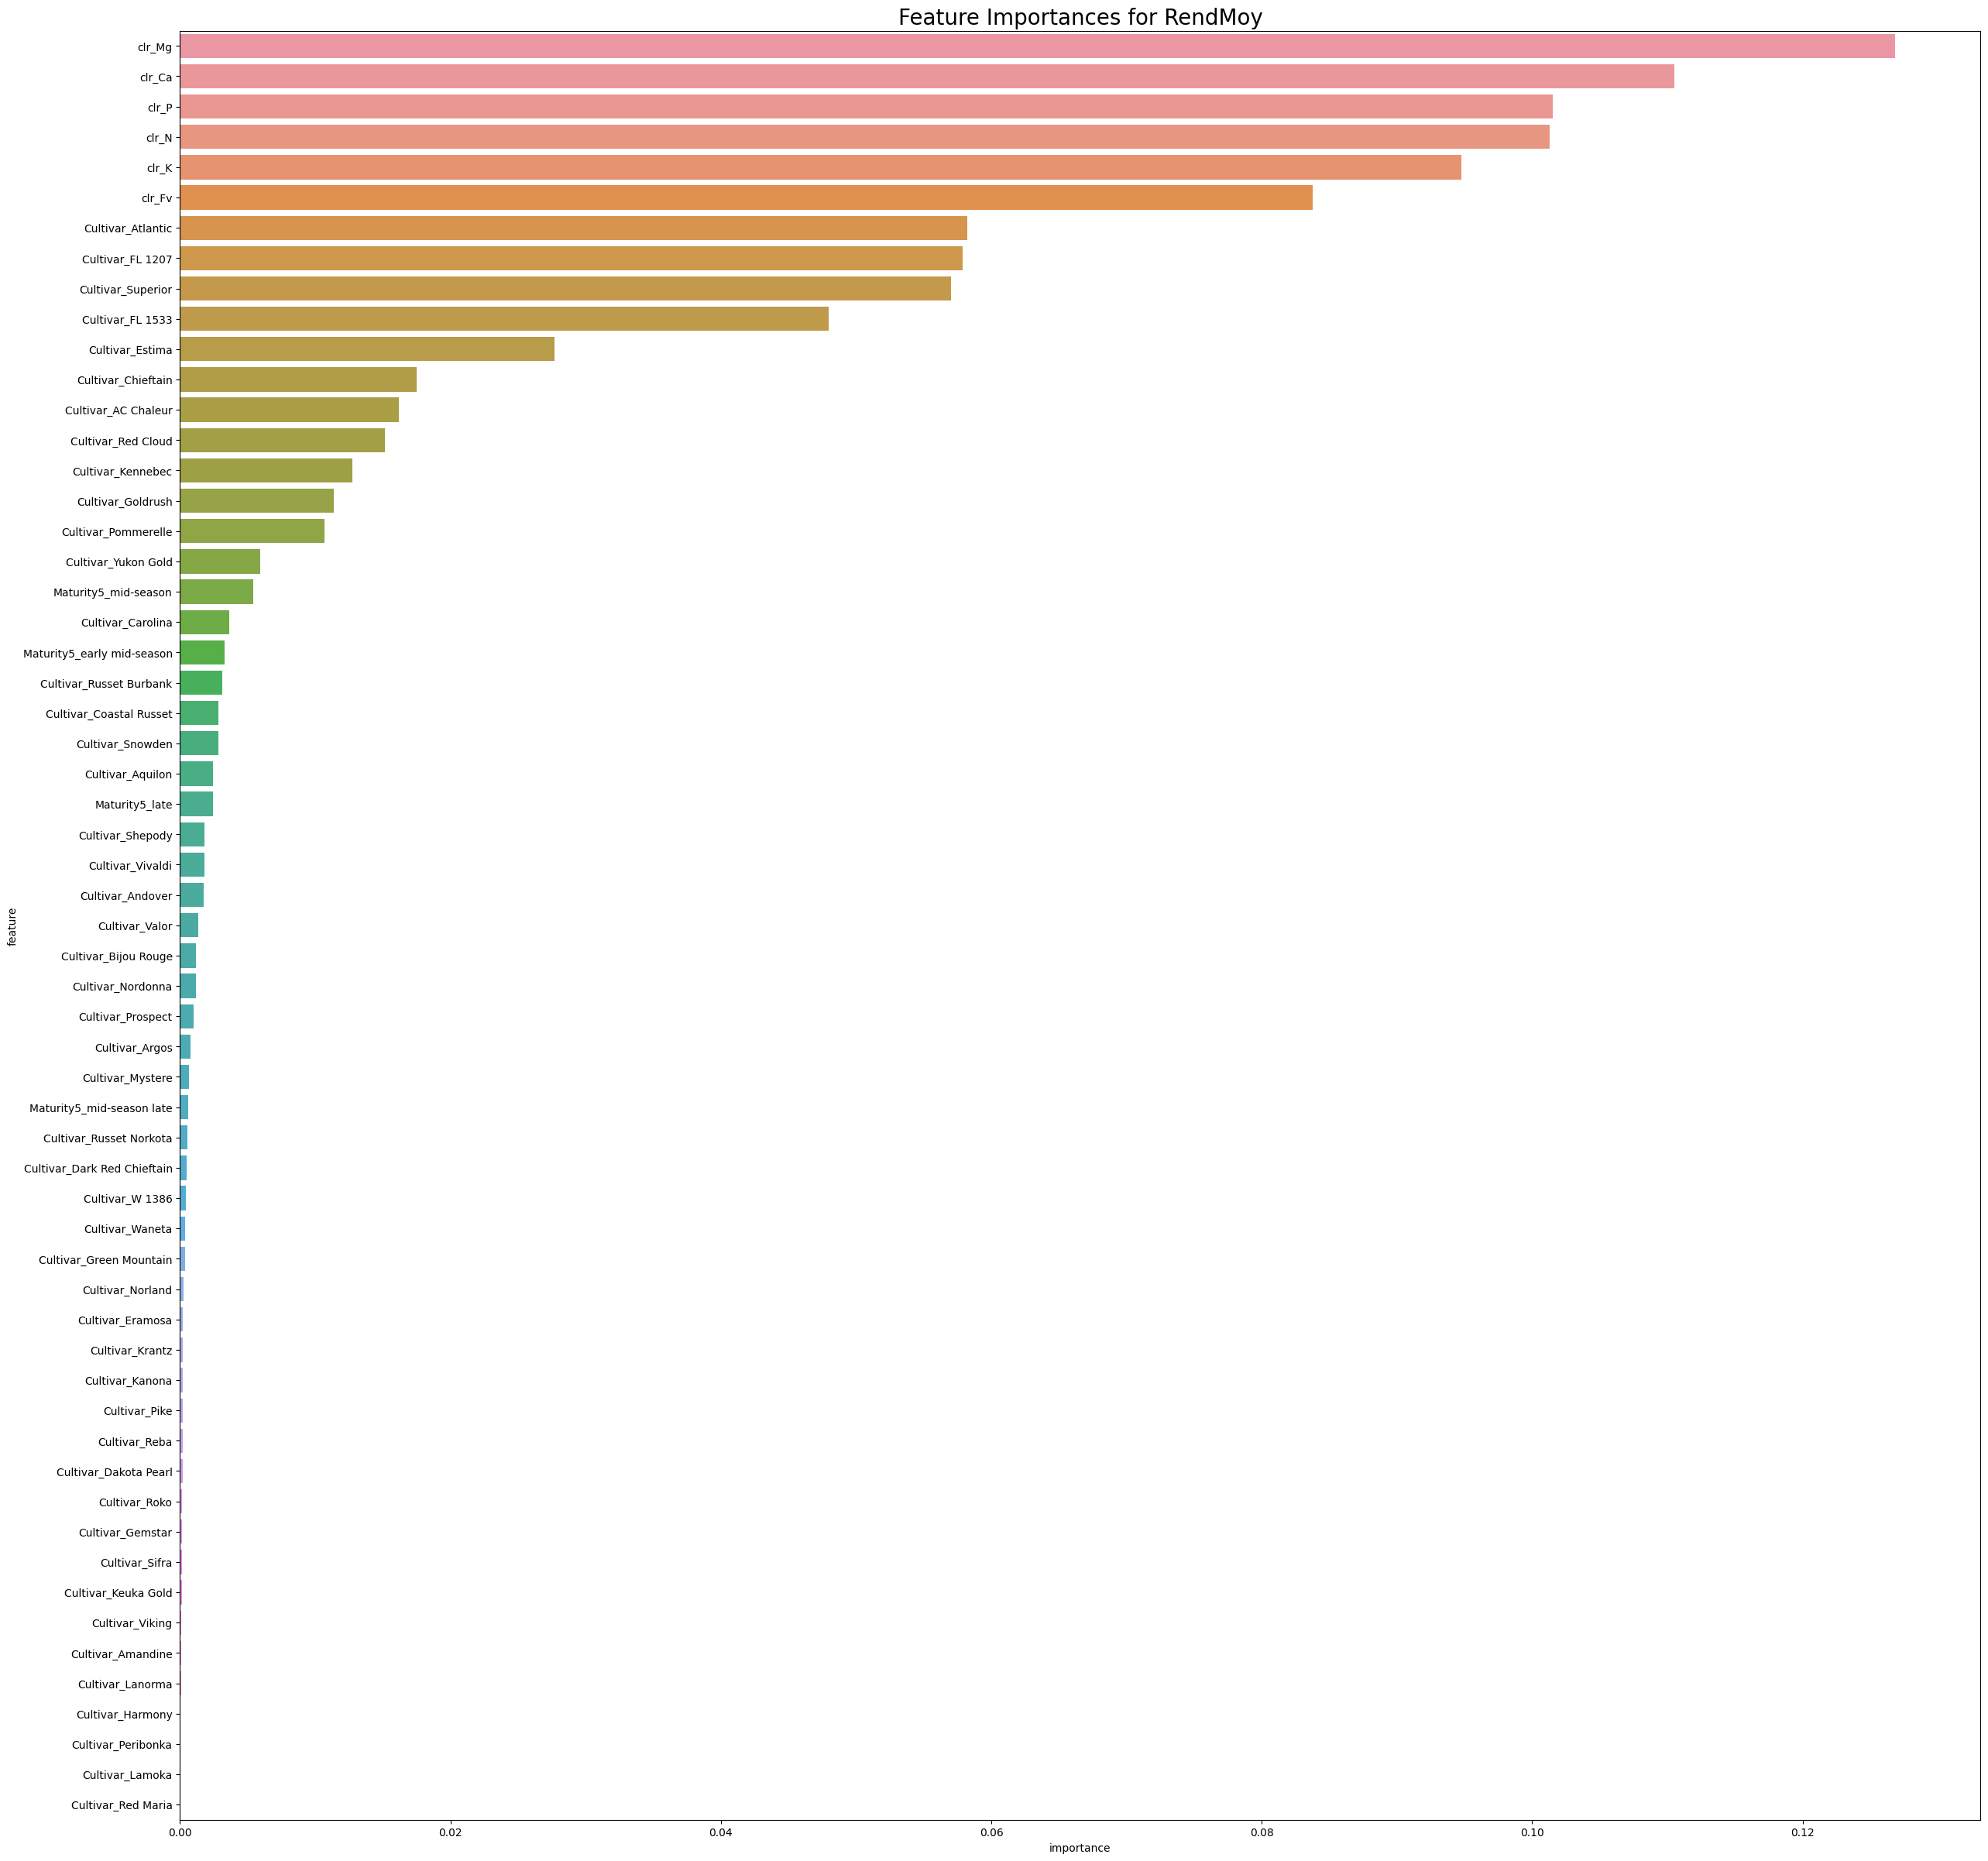

In [38]:
feature_importances = pd.DataFrame({'feature': new_features,
                                    'importance': rf_best.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(30, 30))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title(f'Feature Importances for {targets[target_idx]}', fontsize=20)
plt.show()


### Evaluation on test data

Random forest regressor evaluation
R2 (explained variance): 0.65
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.25
Mean Absolute Error (Σ|y-pred|/n): 5
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 6
Max Error: 26


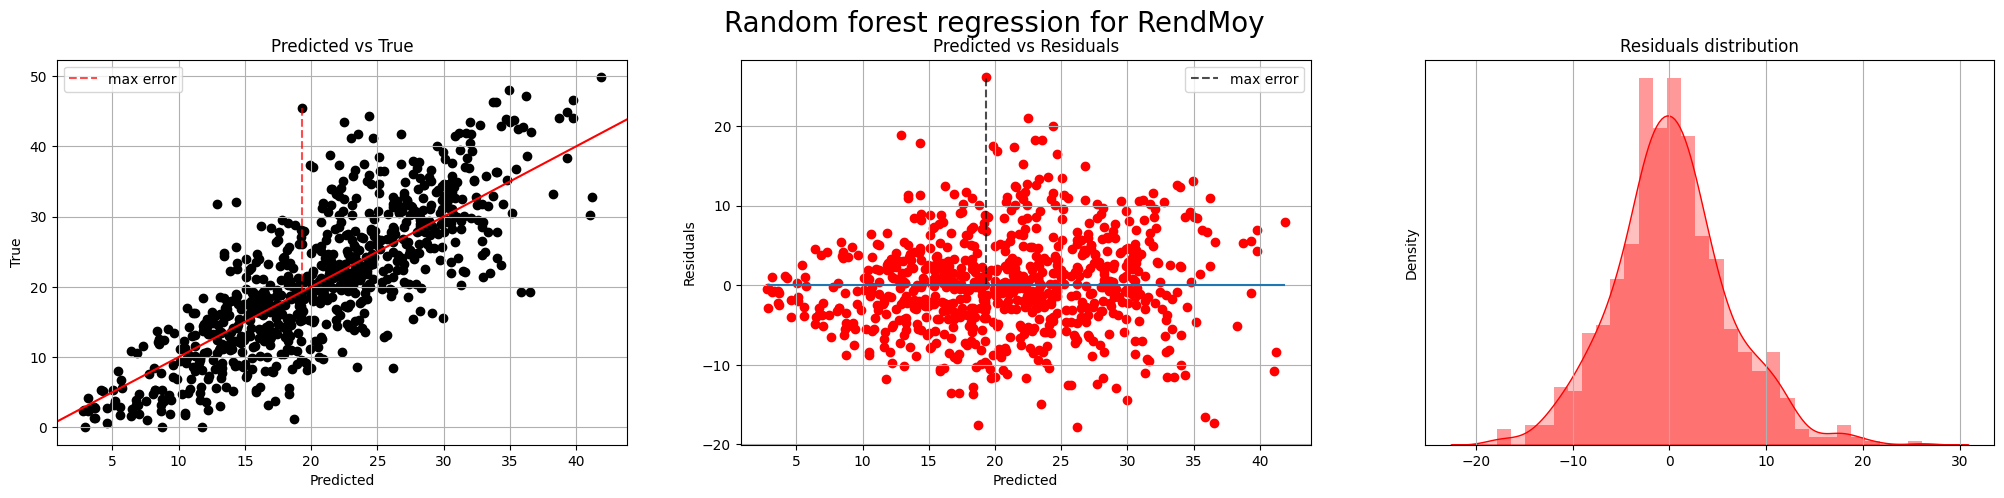


Linear Regression evaluation
R2 (explained variance): 0.42
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.33
Mean Absolute Error (Σ|y-pred|/n): 6
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 8
Max Error: 26


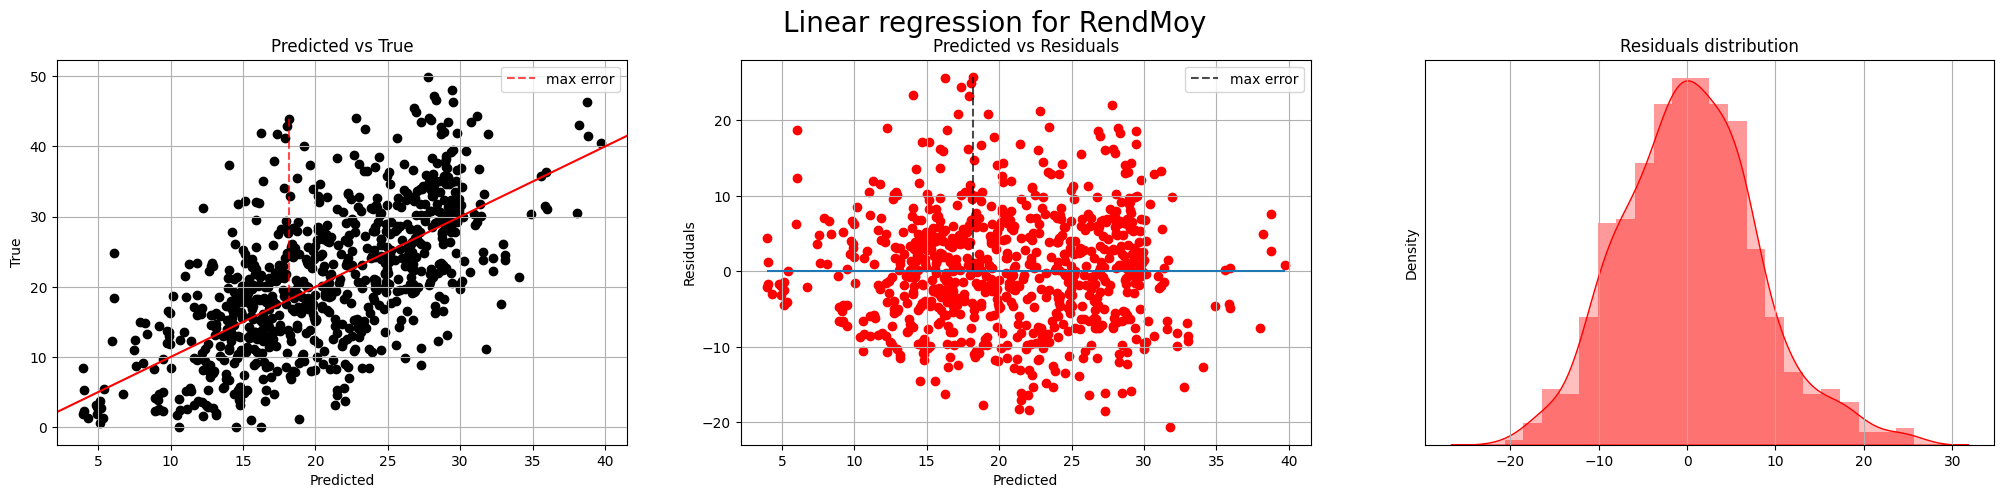


Multi-layer perceptron evaluation
R2 (explained variance): 0.63
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.29
Mean Absolute Error (Σ|y-pred|/n): 5
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 6
Max Error: 24


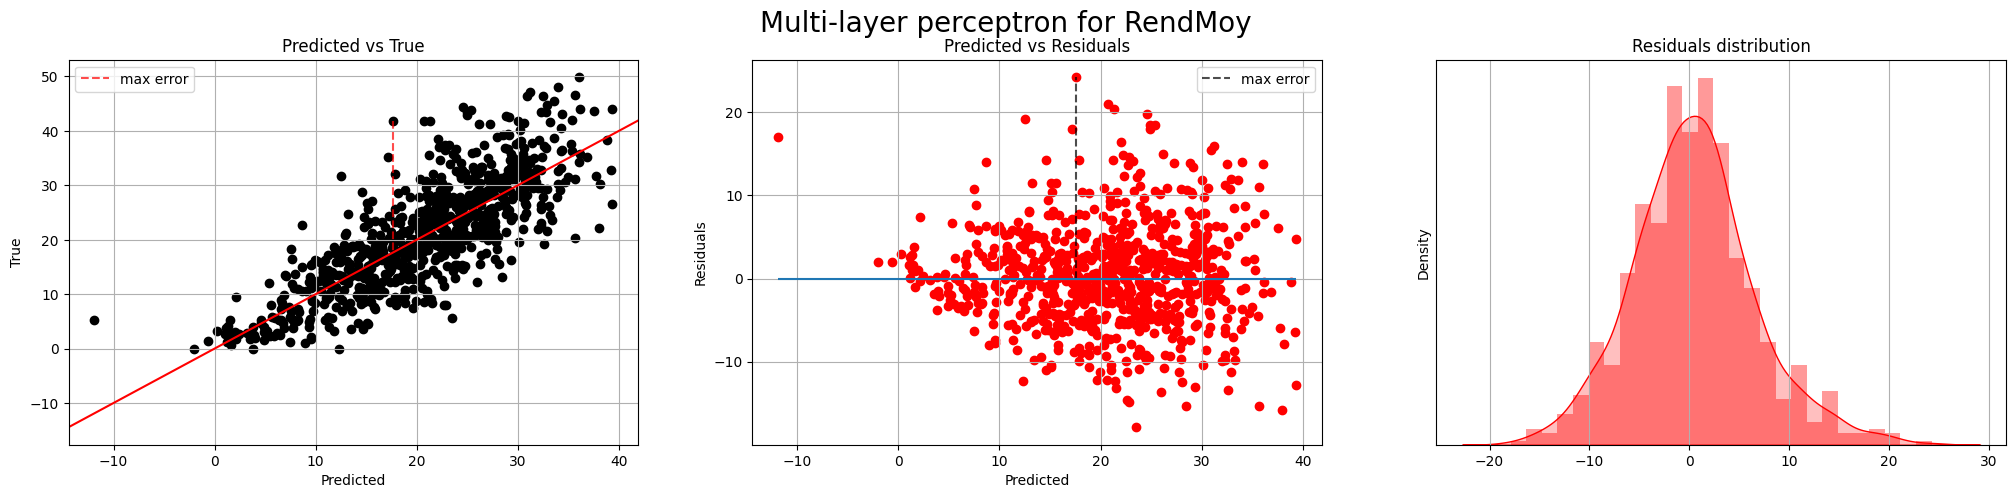

In [39]:
# Evaluate on test data
real_y_test = y_scaler.inverse_transform([y_test])  # Inverse transform to get back to real distribution
real_y_pred_rf = y_scaler.inverse_transform([y_pred_rf])
real_y_pred_lr = y_scaler.inverse_transform([y_pred_lr])
real_y_pred_nn = y_scaler.inverse_transform([y_pred_nn])

print("Random forest regressor evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_rf[0], plt_title=f"Random forest regression for {targets[target_idx]}")
print()

print("Linear Regression evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_lr[0], plt_title=f"Linear regression for {targets[target_idx]}")
print()

print("Multi-layer perceptron evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_nn[0], plt_title=f"Multi-layer perceptron for {targets[target_idx]}")
print()

In [40]:
joblib.dump(rf_best, 'models/randomForest_RendMoy.pkl')
joblib.dump(lr_best, 'models/linearRegression_RendMoy.pkl')
joblib.dump(nn_best, 'models/multilayerPerceptron_RendMoy.pkl')

['models/multilayerPerceptron_RendMoy.pkl']

# Target = RendGros

### Train / test split

In [41]:
from sklearn.model_selection import train_test_split

# Train/test split

target_idx = 3  # Decide what variable to consider target from list ['RendVendable', 'RendPetit', 'RendMoy', 'RendGros']
X = df[new_features]
y = df[targets[target_idx]]
print(f"Target = {targets[target_idx]}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8539)


Target = RendGros


### Scaling

In [42]:
from sklearn.preprocessing import StandardScaler

# Scaling
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train[numerical] = X_scaler.fit_transform(X_train[numerical])
X_test[numerical] = X_scaler.transform(X_test[numerical])
y_train = y_scaler.fit_transform(pd.DataFrame(y_train, columns=[targets[target_idx]])).ravel()
y_test = y_scaler.transform(pd.DataFrame(y_test, columns=[targets[target_idx]])).ravel()

In [43]:
with open('models/RendGros_scaler.pickle', 'wb') as output:
    pickle.dump(y_scaler, output)

### Fitting Random Forest, Linear Regression & Multilayer perceptron

In [44]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV



rf = RandomForestRegressor(random_state=42)  # Random Forest
lr = LinearRegression()  # Linear Regression
nn = MLPRegressor()  # Multi-layer perceptron


# Define the grid of hyperparameters to search over
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lr_params = {
    'fit_intercept': [True, False]
}

nn_params = {
    'hidden_layer_sizes': [(10,), (20,), (40,), (50,)],
    'activation': ['relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}


# Create a grid search objects
rf_gs = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1)
lr_gs = GridSearchCV(estimator=lr, param_grid=lr_params, cv=3, n_jobs=-1)
nn_gs = GridSearchCV(estimator=nn, param_grid=nn_params, cv=3, n_jobs=-1)


# Fit the grid search objects to the data
rf_gs.fit(X_train, y_train)
lr_gs.fit(X_train, y_train)
nn_gs.fit(X_train, y_train)


# Print the best hyperparameters and best score
print("Random Forest - Best Hyperparameters:", rf_gs.best_params_)
print("Random Forest - Best Score:", rf_gs.best_score_)
print()
print("Linear Regression - Best Hyperparameters:", lr_gs.best_params_)
print("Linear Regression - Best Score:", lr_gs.best_score_)
print()
print("Multi-layer perceptron - Best Hyperparameters:", nn_gs.best_params_)
print("Multi-layer perceptron - Best Score:", nn_gs.best_score_)
print("---------------")

# Evaluate the best model on the test data
rf_best = rf_gs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE on test data:", mse)

lr_best = lr_gs.best_estimator_
y_pred_lr = lr_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE on test data:", mse)

nn_best = nn_gs.best_estimator_
y_pred_nn = nn_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred_nn)
print("Multi-layer perceptron MSE on test data:", mse)

Random Forest - Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Best Score: 0.6731981315875343

Linear Regression - Best Hyperparameters: {'fit_intercept': False}
Linear Regression - Best Score: -2.0150165254054134e+18

Multi-layer perceptron - Best Hyperparameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Multi-layer perceptron - Best Score: 0.6362842925112772
---------------
Random Forest MSE on test data: 0.2811844564545376
Linear Regression MSE on test data: 0.5986930607533164
Multi-layer perceptron MSE on test data: 0.35917405570849104


### Plot feature importances


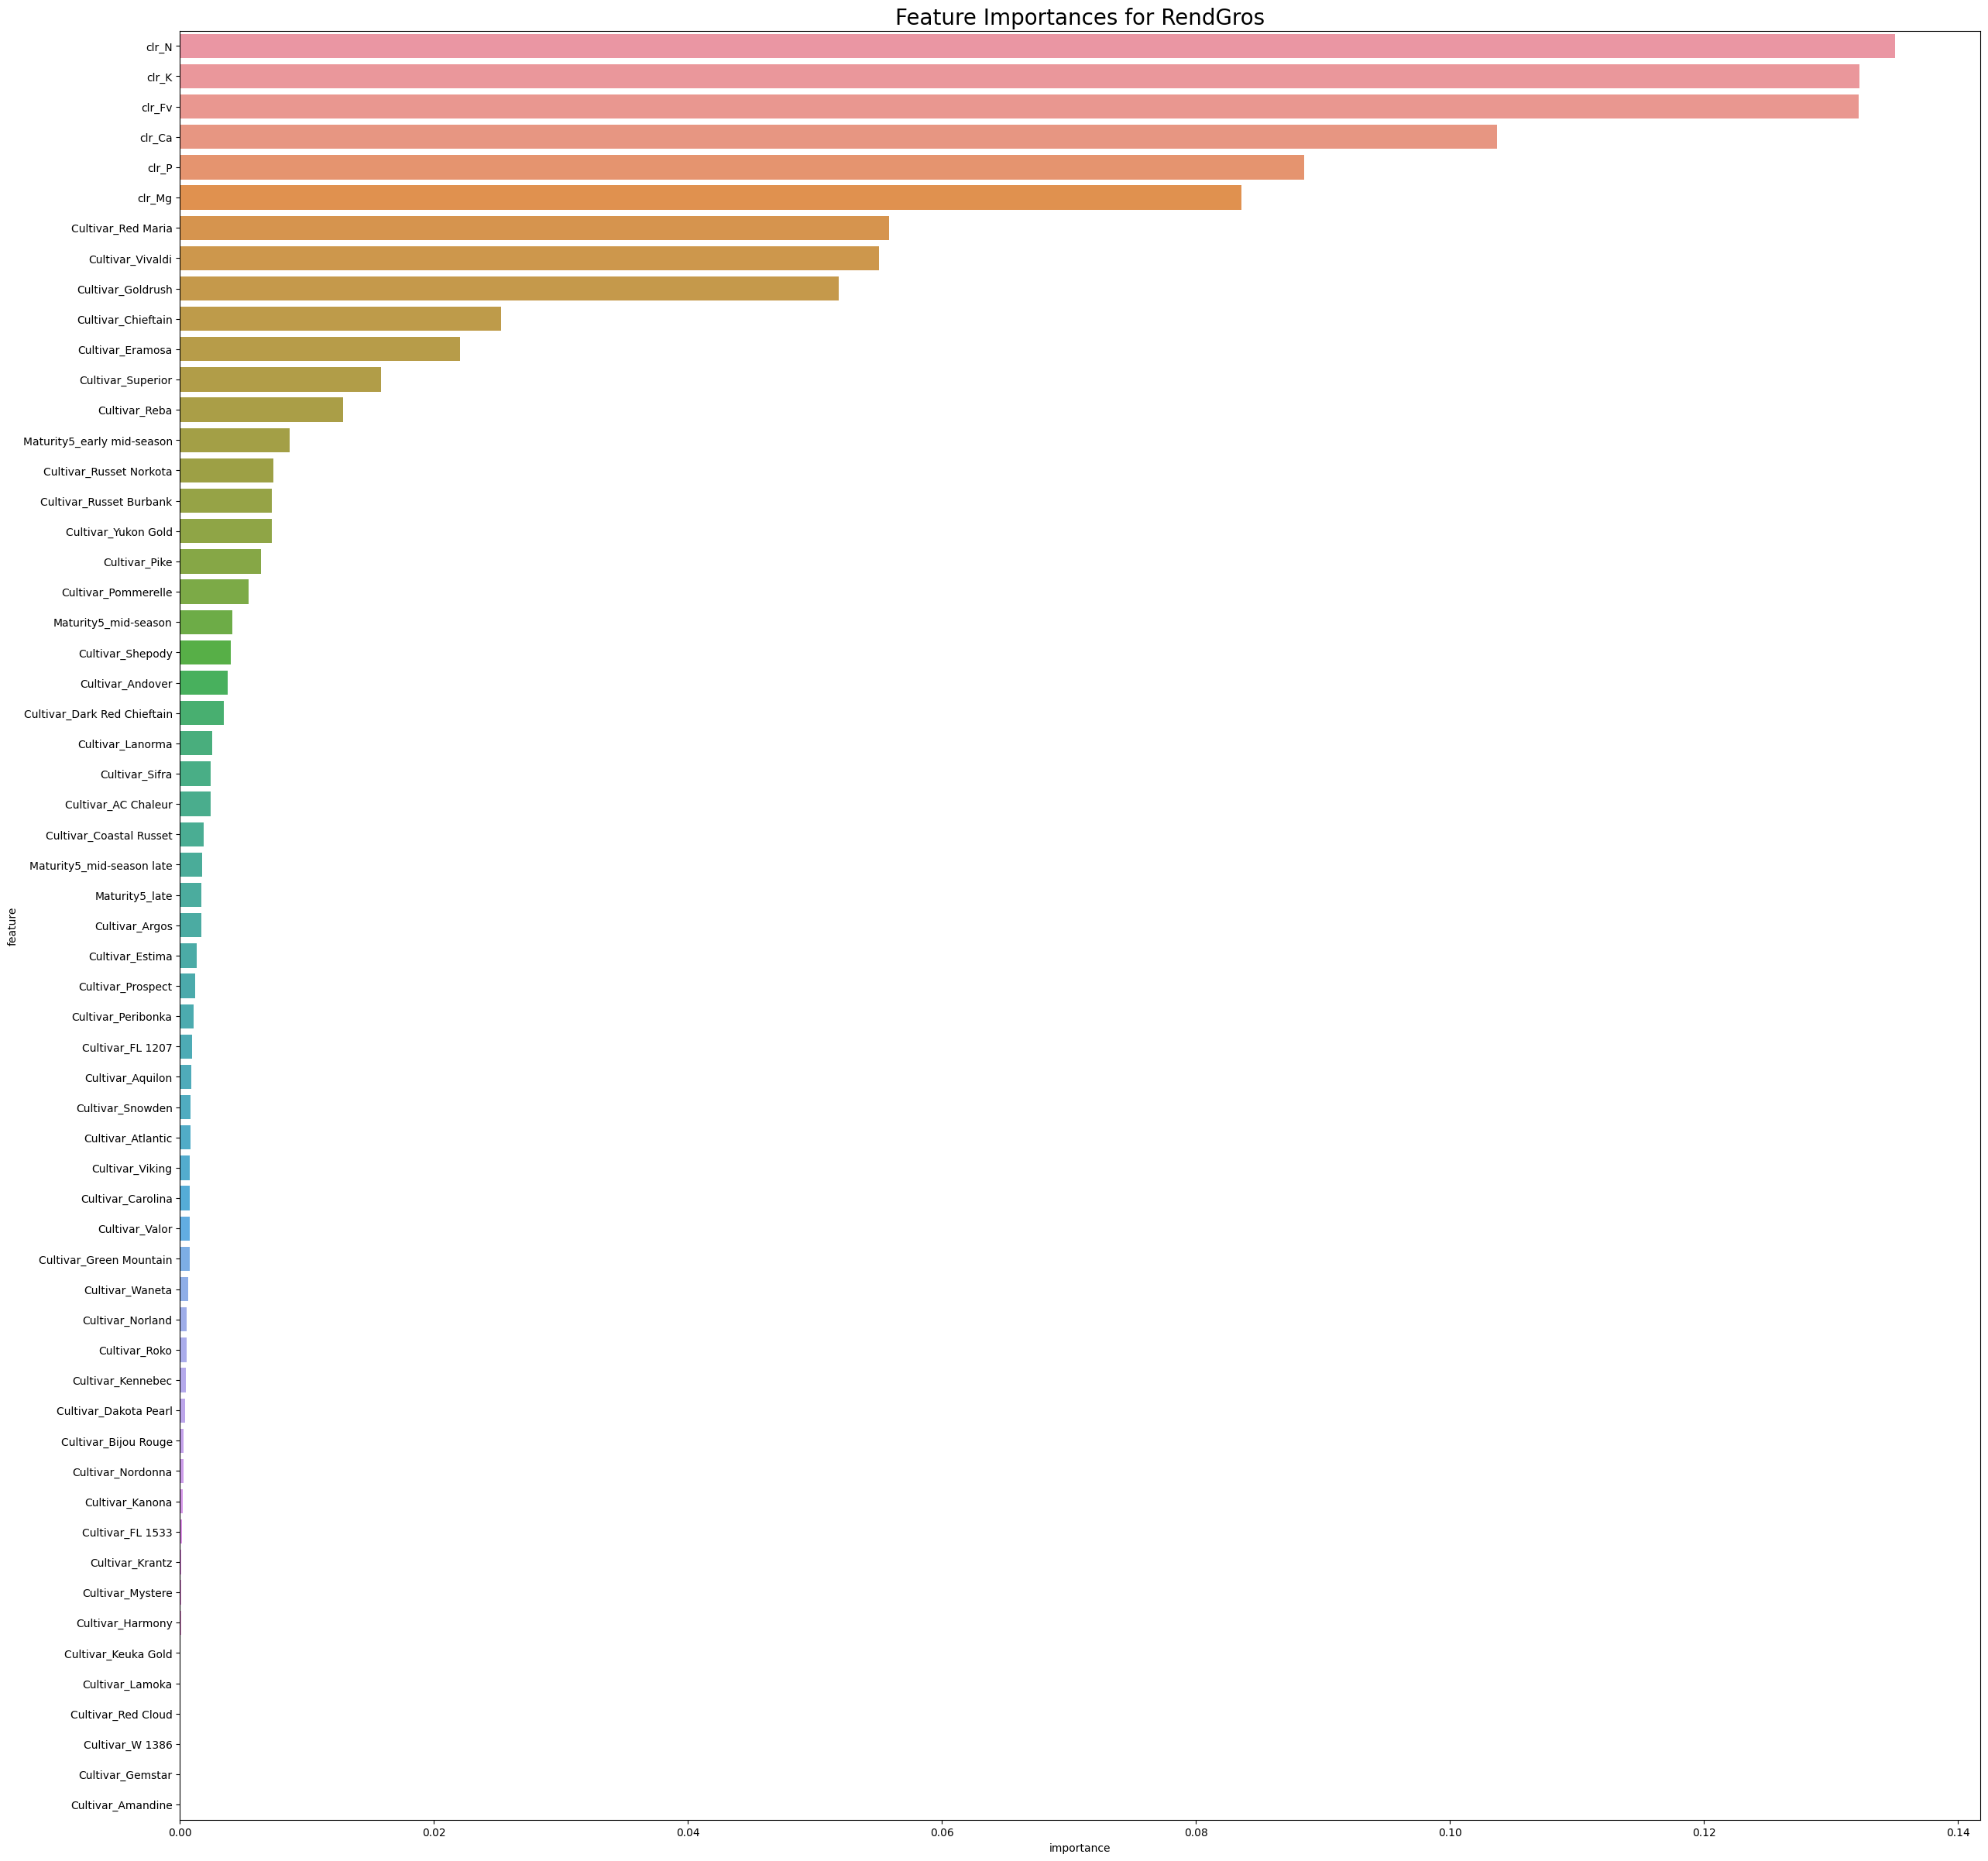

In [45]:
feature_importances = pd.DataFrame({'feature': new_features,
                                    'importance': rf_best.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(30, 30))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title(f'Feature Importances for {targets[target_idx]}', fontsize=20)
plt.show()


### Evaluation on test data

Random forest regressor evaluation
R2 (explained variance): 0.68
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.67
Mean Absolute Error (Σ|y-pred|/n): 3
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 4
Max Error: -21


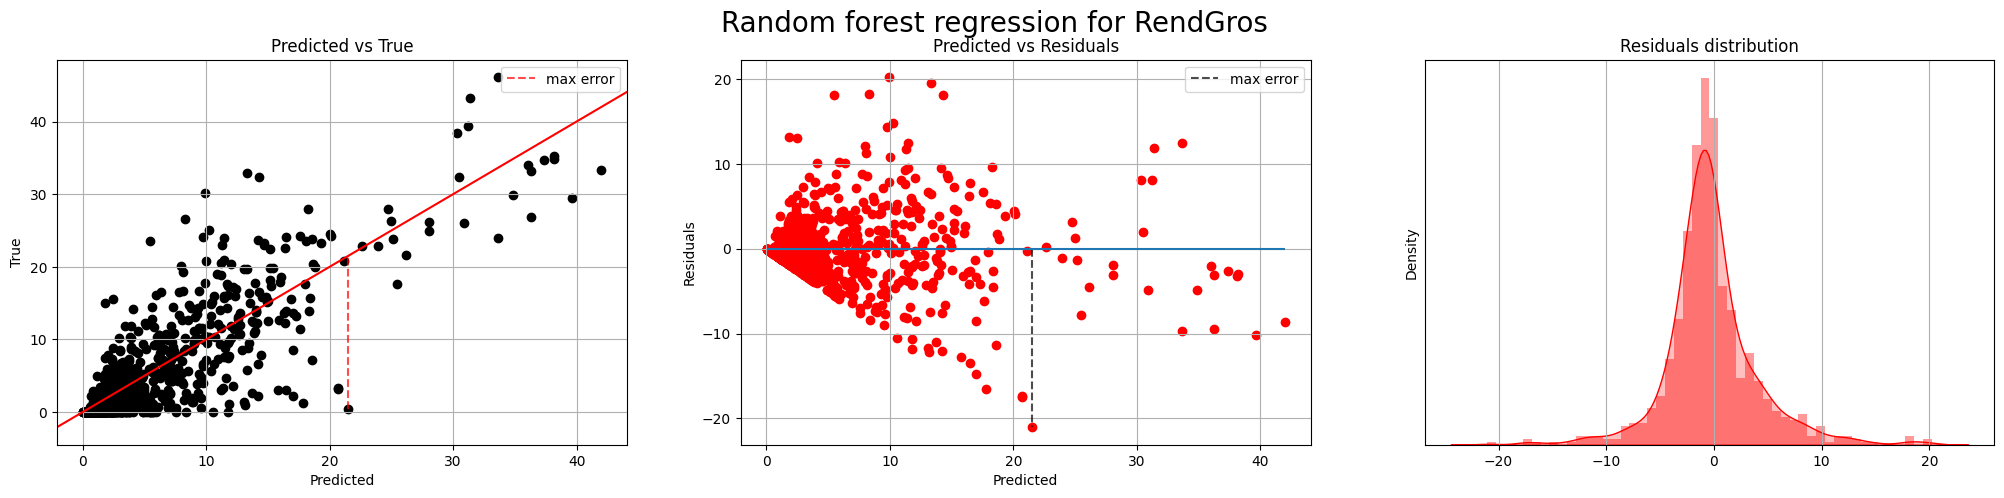


Linear Regression evaluation
R2 (explained variance): 0.33
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 2.58
Mean Absolute Error (Σ|y-pred|/n): 4
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 6
Max Error: 29


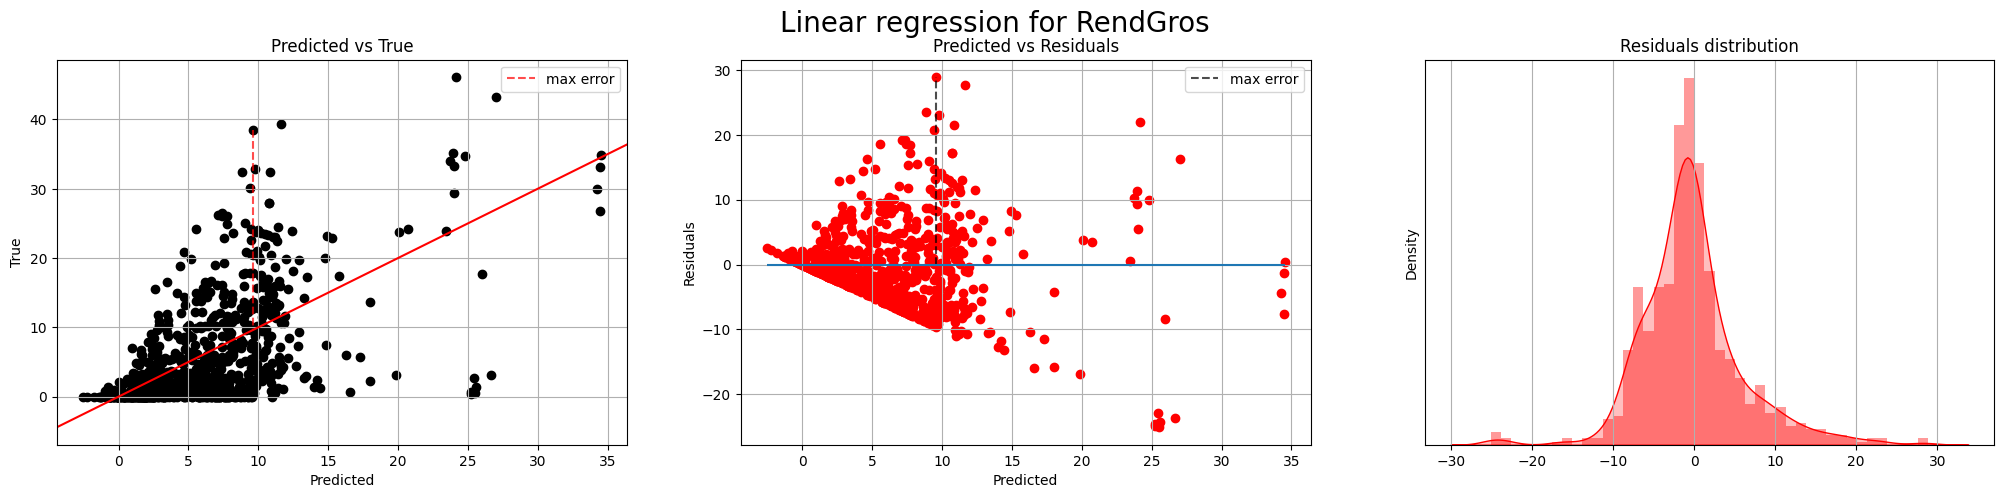


Multi-layer perceptron evaluation
R2 (explained variance): 0.6
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 1.47
Mean Absolute Error (Σ|y-pred|/n): 3
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 5
Max Error: -32


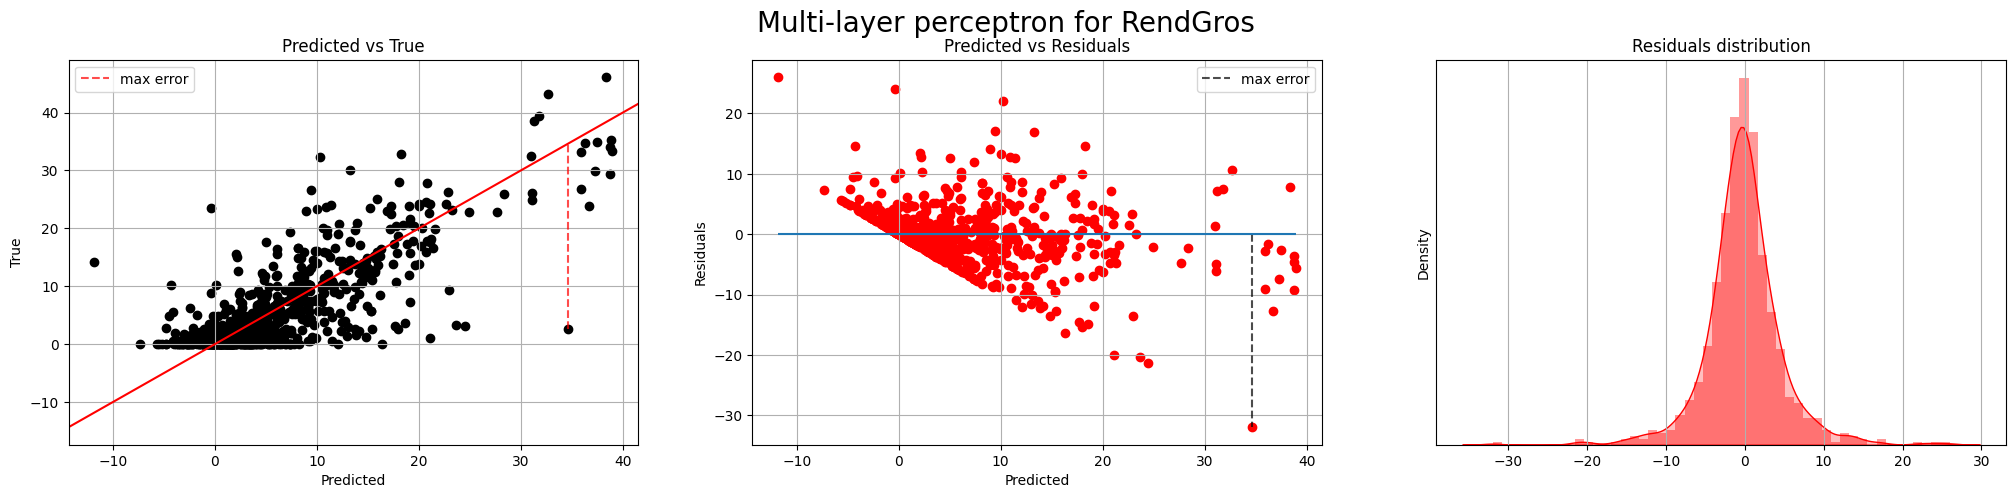

In [46]:
# Evaluate on test data
real_y_test = y_scaler.inverse_transform([y_test])  # Inverse transform to get back to real distribution
real_y_pred_rf = y_scaler.inverse_transform([y_pred_rf])
real_y_pred_lr = y_scaler.inverse_transform([y_pred_lr])
real_y_pred_nn = y_scaler.inverse_transform([y_pred_nn])

print("Random forest regressor evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_rf[0], plt_title=f"Random forest regression for {targets[target_idx]}")
print()

print("Linear Regression evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_lr[0], plt_title=f"Linear regression for {targets[target_idx]}")
print()

print("Multi-layer perceptron evaluation")
evaluate_regression_model(y_test=real_y_test[0], predicted=real_y_pred_nn[0], plt_title=f"Multi-layer perceptron for {targets[target_idx]}")
print()

In [47]:
joblib.dump(rf_best, 'models/randomForest_RendGros.pkl')
joblib.dump(lr_best, 'models/linearRegression_RendGros.pkl')
joblib.dump(nn_best, 'models/multilayerPerceptron_RendGros.pkl')

['models/multilayerPerceptron_RendGros.pkl']